In [1]:
# standard loads
import numpy as np #type:ignore
import matplotlib.pyplot as plt #type:ignore
from matplotlib.colors import ListedColormap #type:ignore
import pandas as pd #type:ignore
import os
import json
import h5py #type:ignore
from skimage import morphology #type:ignore
from skimage.morphology import skeletonize #type:ignore
from skimage.morphology import dilation, disk # type: ignore
from scipy import ndimage # type: ignore
import time
import warnings
warnings.filterwarnings("ignore") # ignore warnings


# import specific algorithm functions
from input_formatting import input_formatting 
from readvardef import readvardef
from Loadlidarmaps import Loadlidarmaps
from RemoveaboveHAT import RemoveaboveHAT
from Creek_Repair import process_creek_mask, save_creek_mask_h5, load_creek_mask_h5, process_creek_mask_diagnostic
from Creek_Ordering import figure_creek_skeleton, process_creek_ordering, process_creek_ordering_diagnostic
from check_plots_step5 import plot_creek_orders, plot_creek_orders_big
from Strahler_Correction_class import CreekNetworkAnalyzer
from Display_Orders import process_creek_orders
from Process_CrossSections import process_xsects, process_xsects_diagnostic
from Process_JunctionAngles import process_junction_angles, process_junction_angles_diagnostic
from Save_Results import process_creek_morphometry, process_creek_morphometry_diagnostic

%config InlineBackend.figure_format='retina' # hig-res plots for a Retina display, uncomment while working

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import line
from skimage.morphology import skeletonize

# canvas
size = 512
image = np.zeros((size, size), dtype=bool)

# ----- drawing helpers -----
def draw_segment(start, end, thickness=1):
    rr, cc = line(start[0], start[1], end[0], end[1])
    for i in range(len(rr)):
        for t in range(-thickness, thickness + 1):
            r = np.clip(rr[i] + t, 0, size - 1)
            c = np.clip(cc[i], 0, size - 1)
            image[r, c] = 1

def draw_square_outline(center, radius):
    y, x = center
    # top/bottom
    for dx in range(-radius, radius + 1):
        if 0 <= y - radius < size and 0 <= x + dx < size:
            image[y - radius, x + dx] = 1
        if 0 <= y + radius < size and 0 <= x + dx < size:
            image[y + radius, x + dx] = 1
    # left/right
    for dy in range(-radius, radius + 1):
        if 0 <= y + dy < size and 0 <= x - radius < size:
            image[y + dy, x - radius] = 1
        if 0 <= y + dy < size and 0 <= x + radius < size:
            image[y + dy, x + radius] = 1

def project_to_square_boundary(point, center, radius):
    """Project vector (point-center) to the square boundary of half-size=radius."""
    py, px = point
    cy, cx = center
    vy, vx = py - cy, px - cx
    if abs(vy) > abs(vx):  # hits top/bottom
        vy = np.sign(vy) * radius
        vx = np.clip(vx, -radius, radius)
    else:                  # hits left/right
        vx = np.sign(vx) * radius
        vy = np.clip(vy, -radius, radius)
    return int(cy + vy), int(cx + vx)

def connect_to_square(start, end, center, radius, thickness=1):
    """Connect start/end to the square *boundary* (never through the interior)."""
    entry = project_to_square_boundary(start, center, radius)
    exit_ = project_to_square_boundary(end,   center, radius)
    draw_segment(start, entry, thickness)
    draw_segment(exit_, end, thickness)

def clear_square_interior(arr, center, radius):
    """Make every pixel strictly inside the square border False."""
    y, x = center
    y0 = max(0, y - radius + 1)
    y1 = min(size, y + radius)     # exclusive
    x0 = max(0, x - radius + 1)
    x1 = min(size, x + radius)     # exclusive
    arr[y0:y1, x0:x1] = False

# ----- geometry -----
main_path   = [(50, 100), (100, 150), (200, 200), (300, 250), (400, 300), (450, 350)]
loop_centers = [(50, 100), (250, 225)]
loop_radius  = 12

# draw main with square connections (1–2 connections depending on segments)
for i in range(len(main_path) - 1):
    s, e = main_path[i], main_path[i + 1]
    if s in loop_centers or e in loop_centers:
        center = s if s in loop_centers else e
        connect_to_square(s, e, center, loop_radius, thickness=1)
    else:
        draw_segment(s, e, thickness=1)

# branches
branches = [
    ((100, 150), (80, 180)),
    ((200, 200), (180, 230)),
    ((300, 250), (290, 270)),
    ((400, 300), (390, 320)),
    ((450, 350), (470, 380)),
    ((450, 350), (511, 450))  # outlet to bottom edge
]
for s, e in branches:
    draw_segment(s, e, thickness=1)

# draw squares
for c in loop_centers:
    draw_square_outline(c, loop_radius)

# **nuke interiors BEFORE skeletonizing**
for c in loop_centers:
    clear_square_interior(image, c, loop_radius)

# skeletonize creek + connections (squares won't generate interior lines now)
skeleton_phony = skeletonize(image)

# **belt-and-suspenders: nuke interiors AGAIN AFTER skeletonizing**
for c in loop_centers:
    clear_square_interior(skeleton_phony, c, loop_radius)

# ---- optional: elevation coloring (same as before) ----
Z = np.full_like(skeleton_phony, np.nan, dtype=float)
coords = np.column_stack(np.nonzero(skeleton_phony))

# force outlet pixel
skeleton_phony[511, 450] = True
lowest_point = np.array([511, 450])

if coords.size:
    d = np.linalg.norm(coords - lowest_point, axis=1)
    m = d.max() if d.size else 1.0
    elev = (d / m) * 100.0
    for (r, c), z in zip(coords, elev):
        Z[r, c] = z

# # visualize
# plt.figure(figsize=(8, 8))
# plt.imshow(skeleton_phony, cmap='gray')
# plt.title("Skeleton with Square Loops (interiors forced False)")
# plt.show()


initial ID =  []
Starting while loop 1 (while there are any endpoints left):
while 1/4, Iteration 1: 5 endpoints remaining
order i =  1
k =  0  of  5


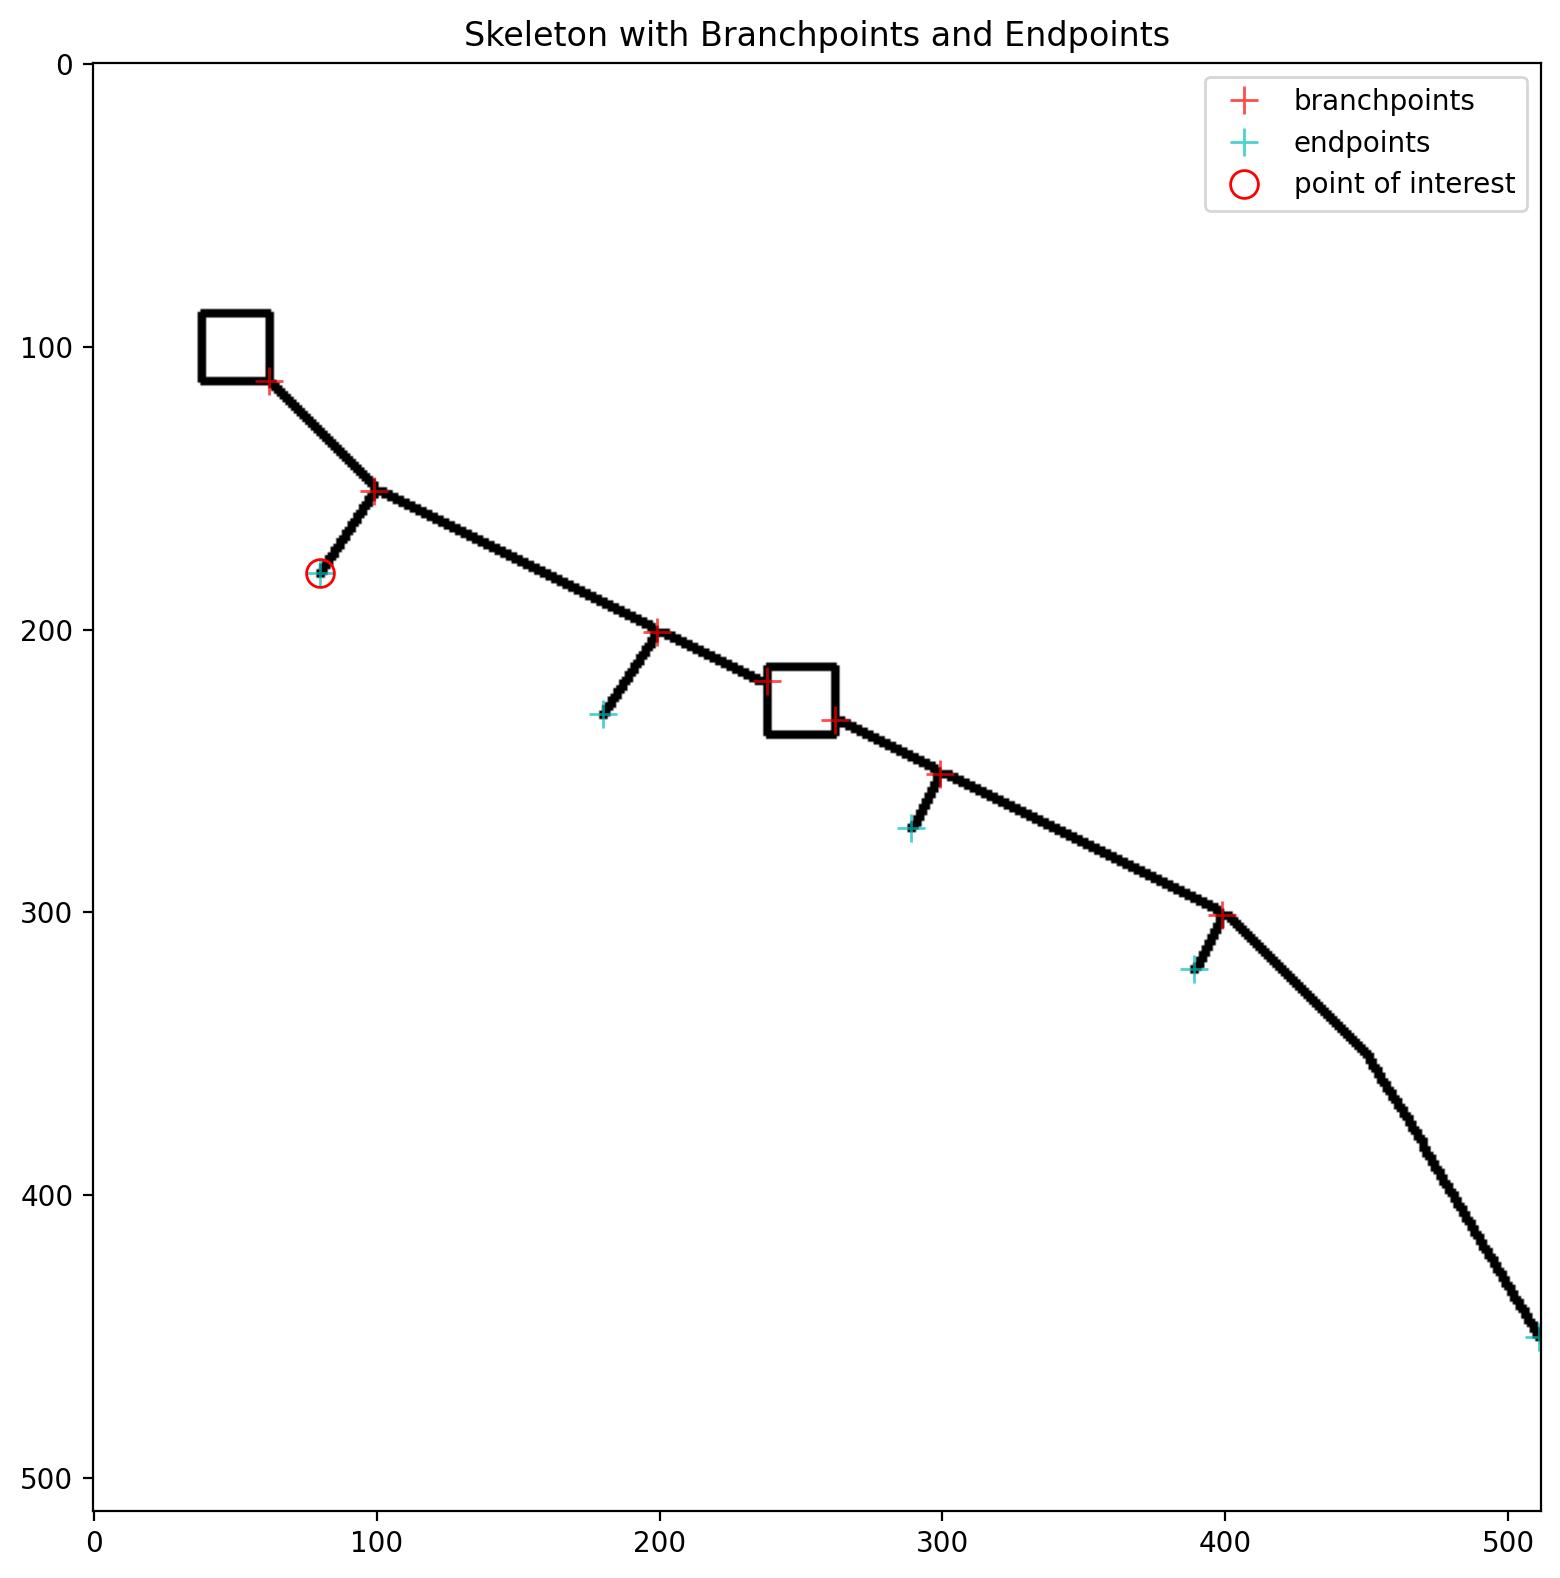

k =  1  of  5
k =  2  of  5
k =  3  of  5
k =  4  of  5
redo skeleton ID =  [1.]
i != ordermax ID =  [1 2 3]

Starting while loop 2 (outlets):
while 2/4, Iteration 1: 1 endpoints remaining
order i =  3
k =  5
k2 =  0  of  1
E location y[k2], x[k2] =  (np.int64(510), np.int64(449))


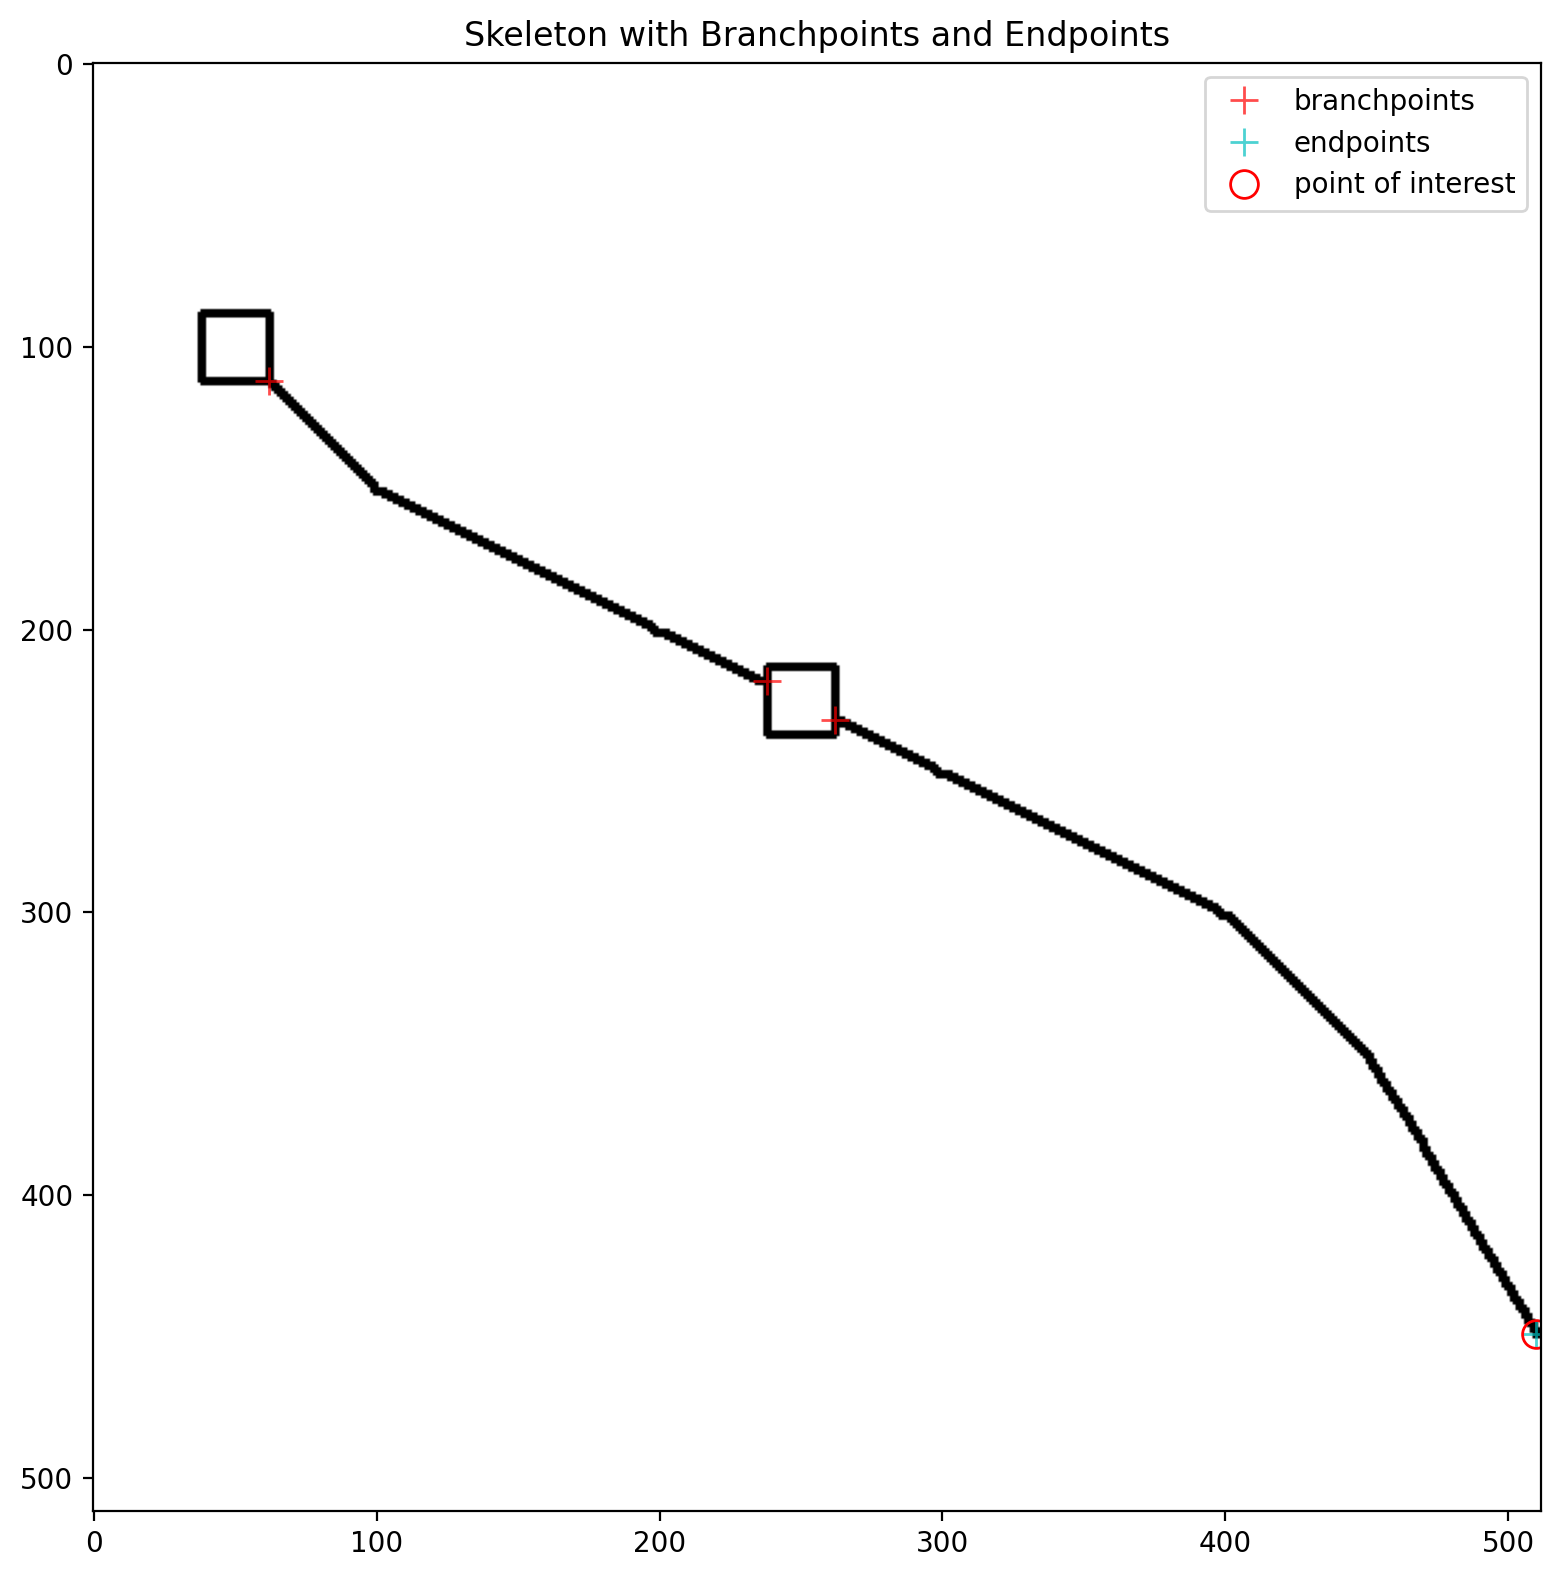

distanceToEndPt =  inf
distanceToBranchPt =  360.7300141024121


Starting while loop 3 (branch points / interconnected segments):
while 3/4, Iteration 1: 2 endpoints remaining
order i =  3
Total skeleton pixels: 361
Number of branch points found: 2
Number of PTS points: 2
B_loc shape: (2, 2)
First few B_loc coordinates: [[ 62 112]
 [238 218]]
len(x) =  2
k =  6
k2 =  0  of  2
E location y[k2], x[k2] =  (np.int64(62), np.int64(112))


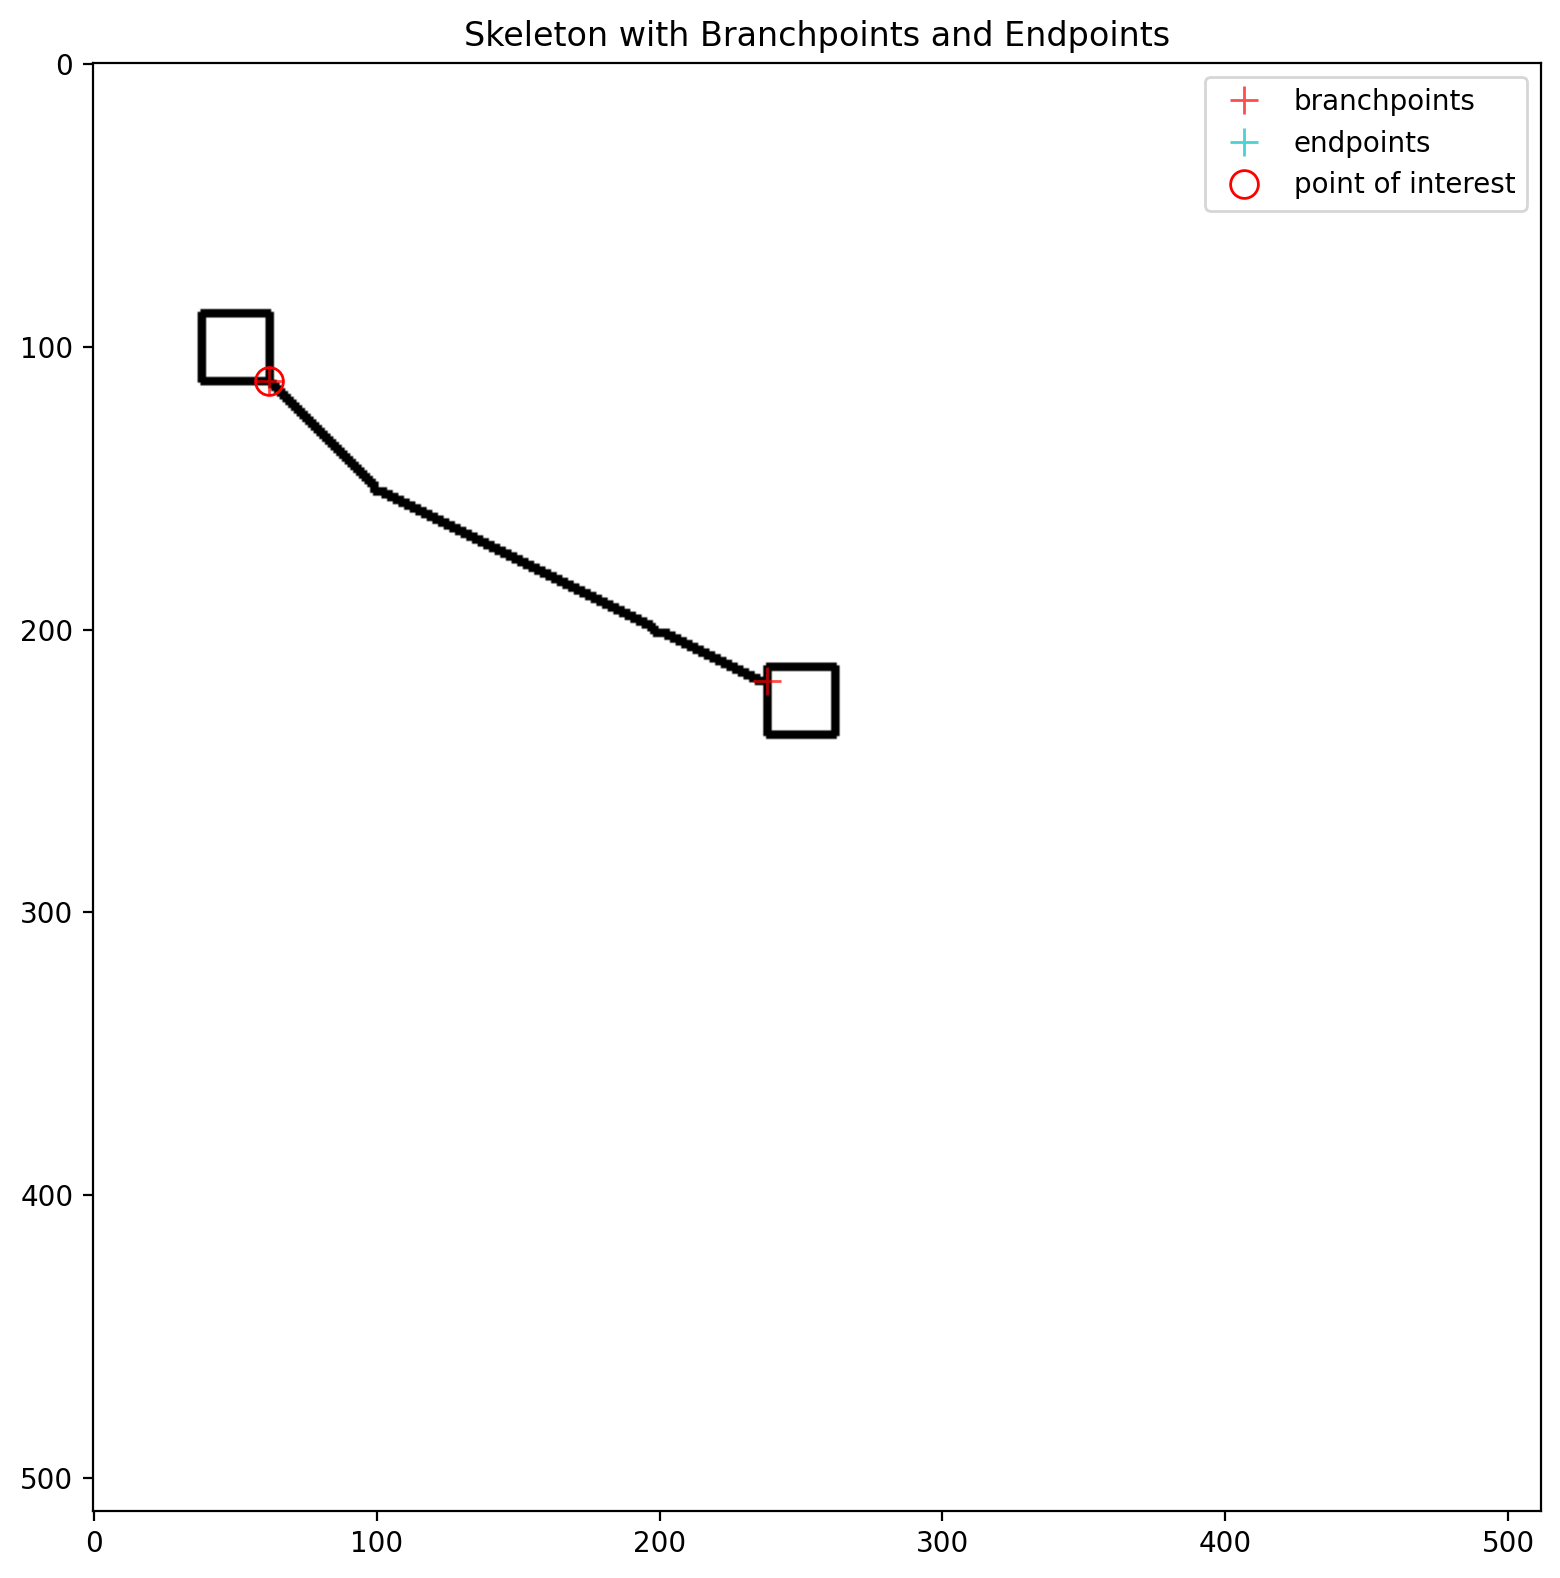

distanceToEndPt =  inf
distanceToBranchPt =  220.4924240491753
   yptend, xptend =  [238] [218]
Start point (np.int64(62), np.int64(112)) in skeleton: True
End point (np.int64(238), np.int64(218)) in skeleton: True
Cost at start: 1.0
Cost at end: 1.0


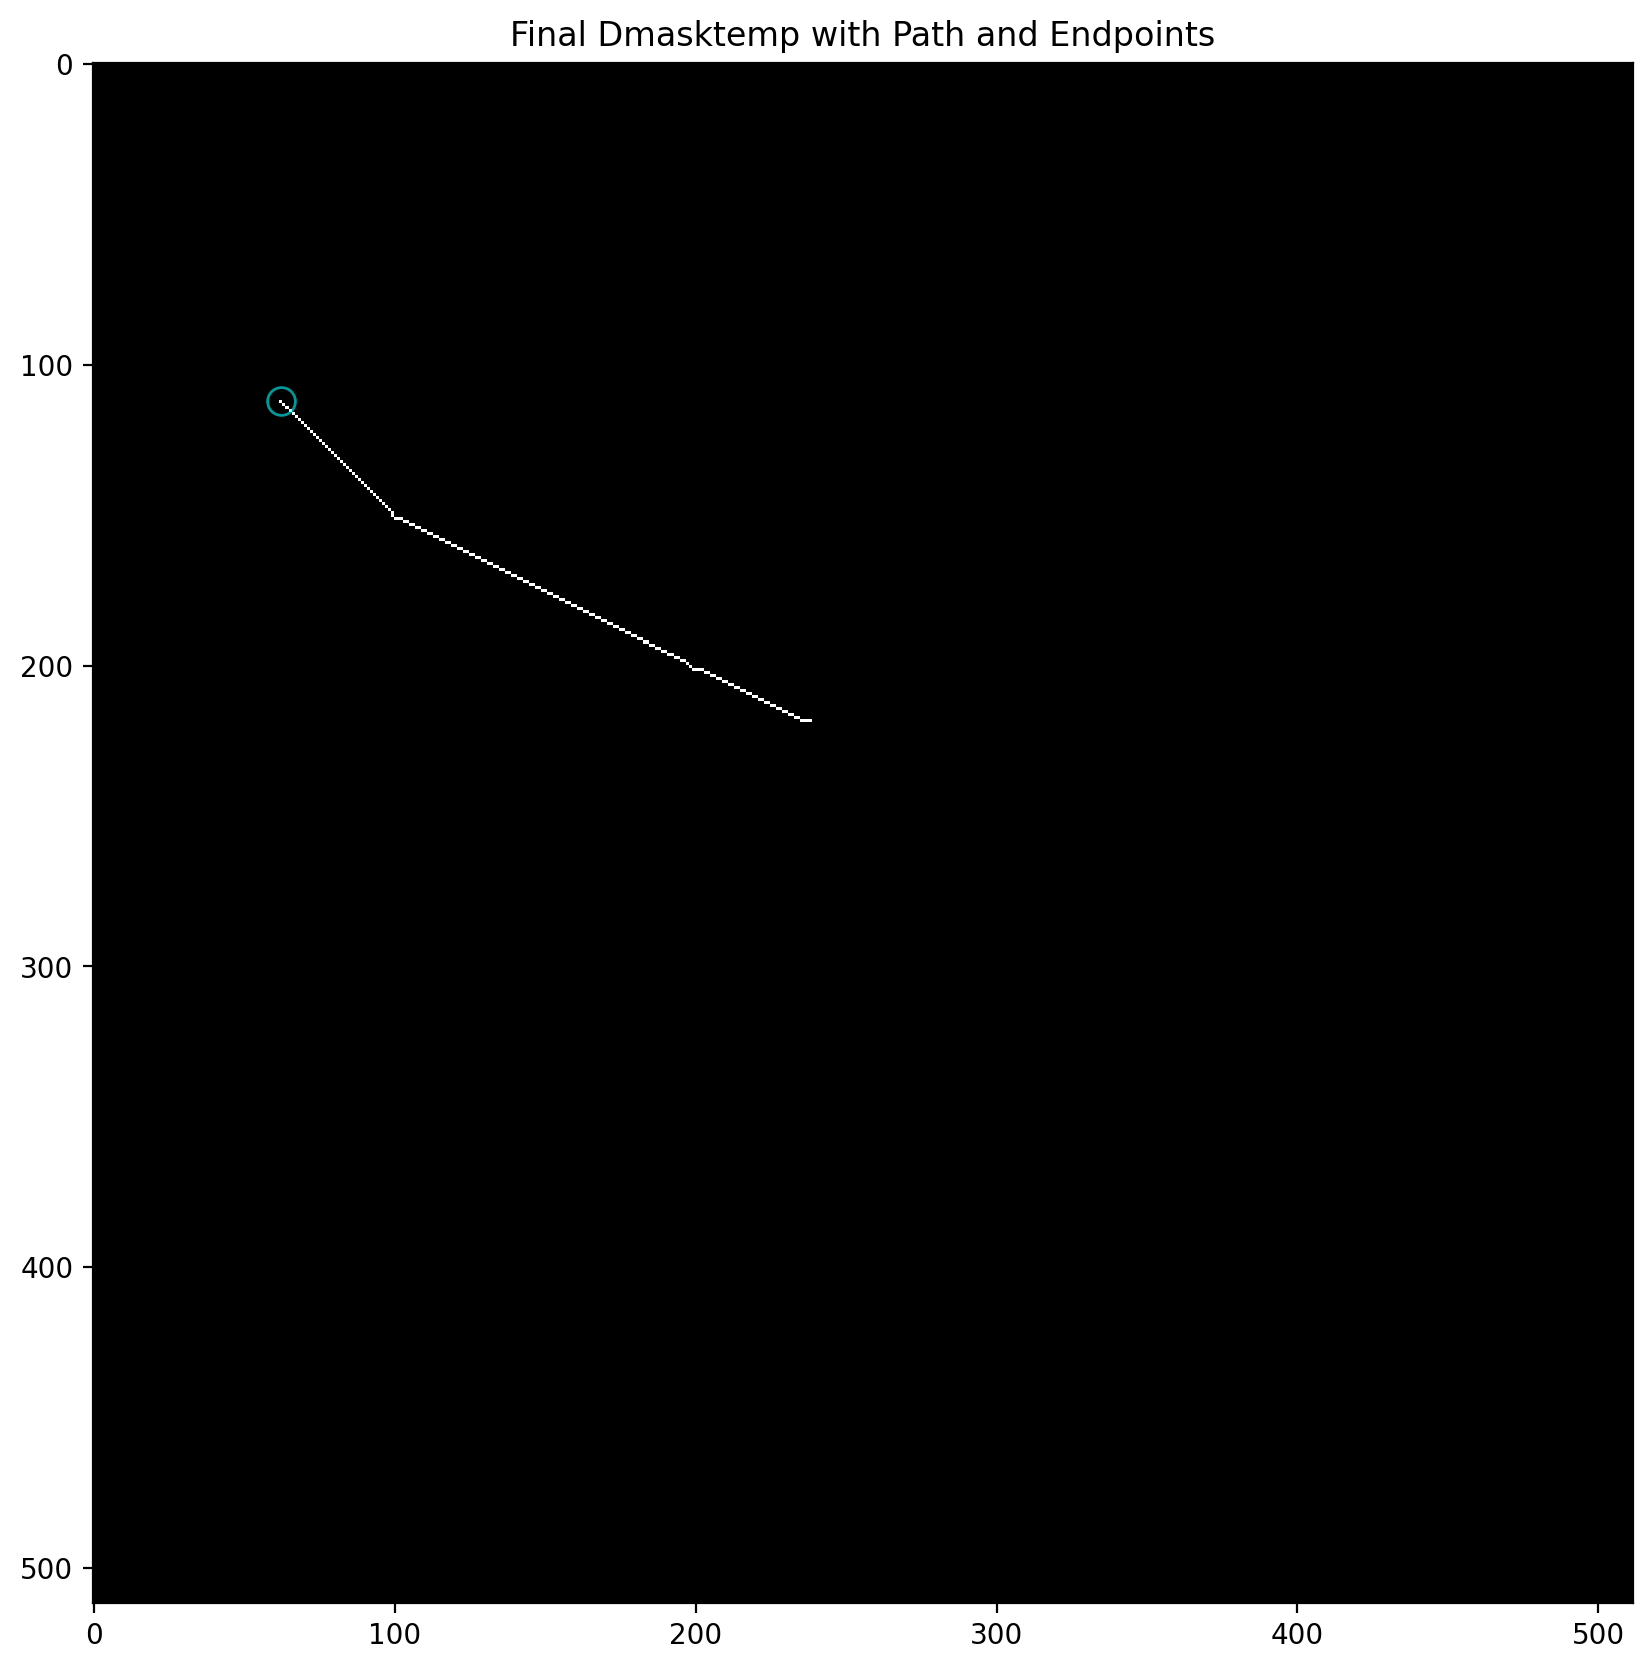


len(x) =  2
k =  7
k2 =  1  of  2
E location y[k2], x[k2] =  (np.int64(238), np.int64(218))


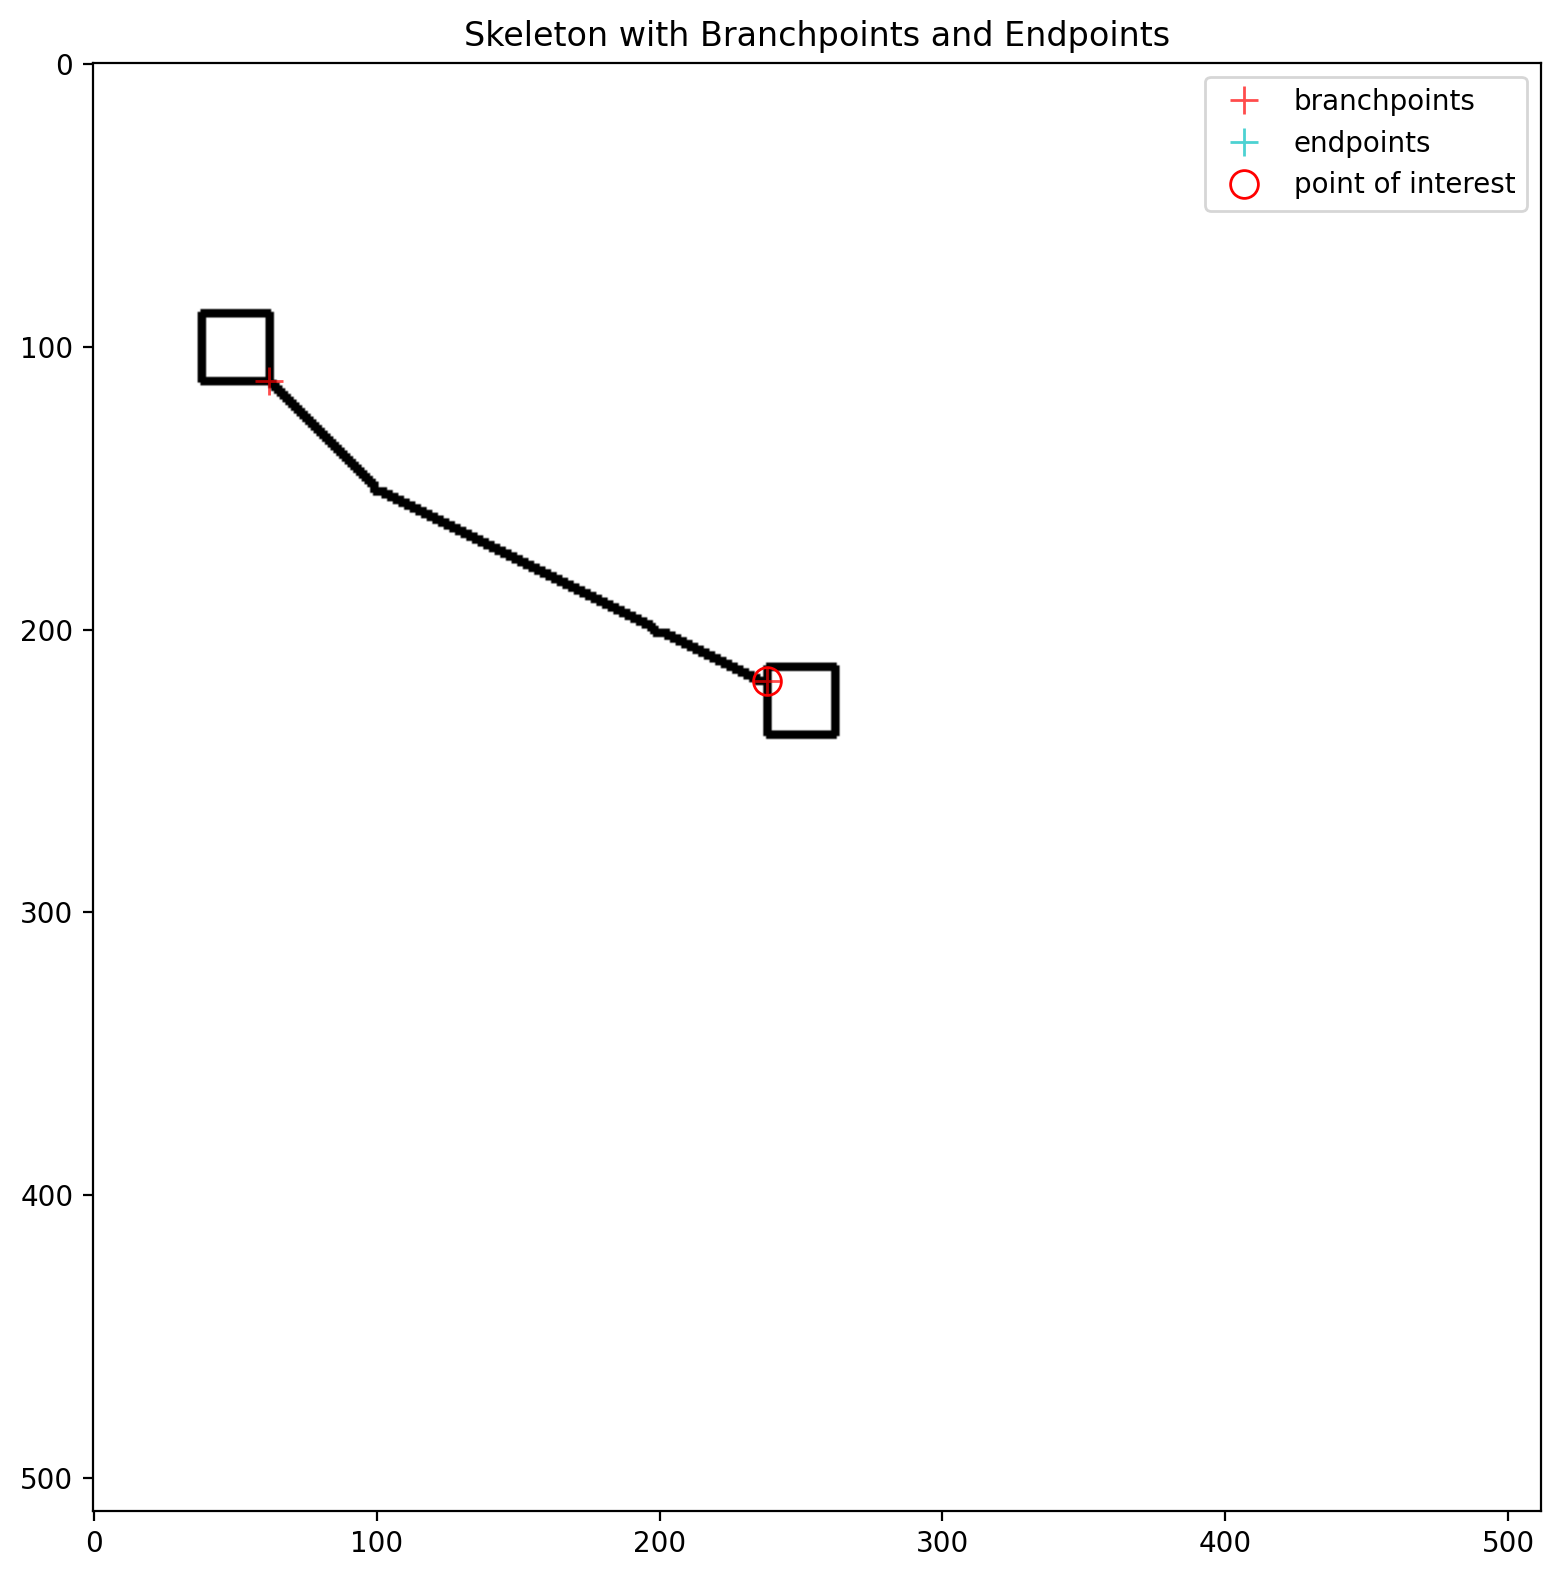

distanceToEndPt =  inf
distanceToBranchPt =  220.4924240491755
   yptend, xptend =  [62] [112]
Start point (np.int64(238), np.int64(218)) in skeleton: True
End point (np.int64(62), np.int64(112)) in skeleton: True
Cost at start: 1.0
Cost at end: 1.0


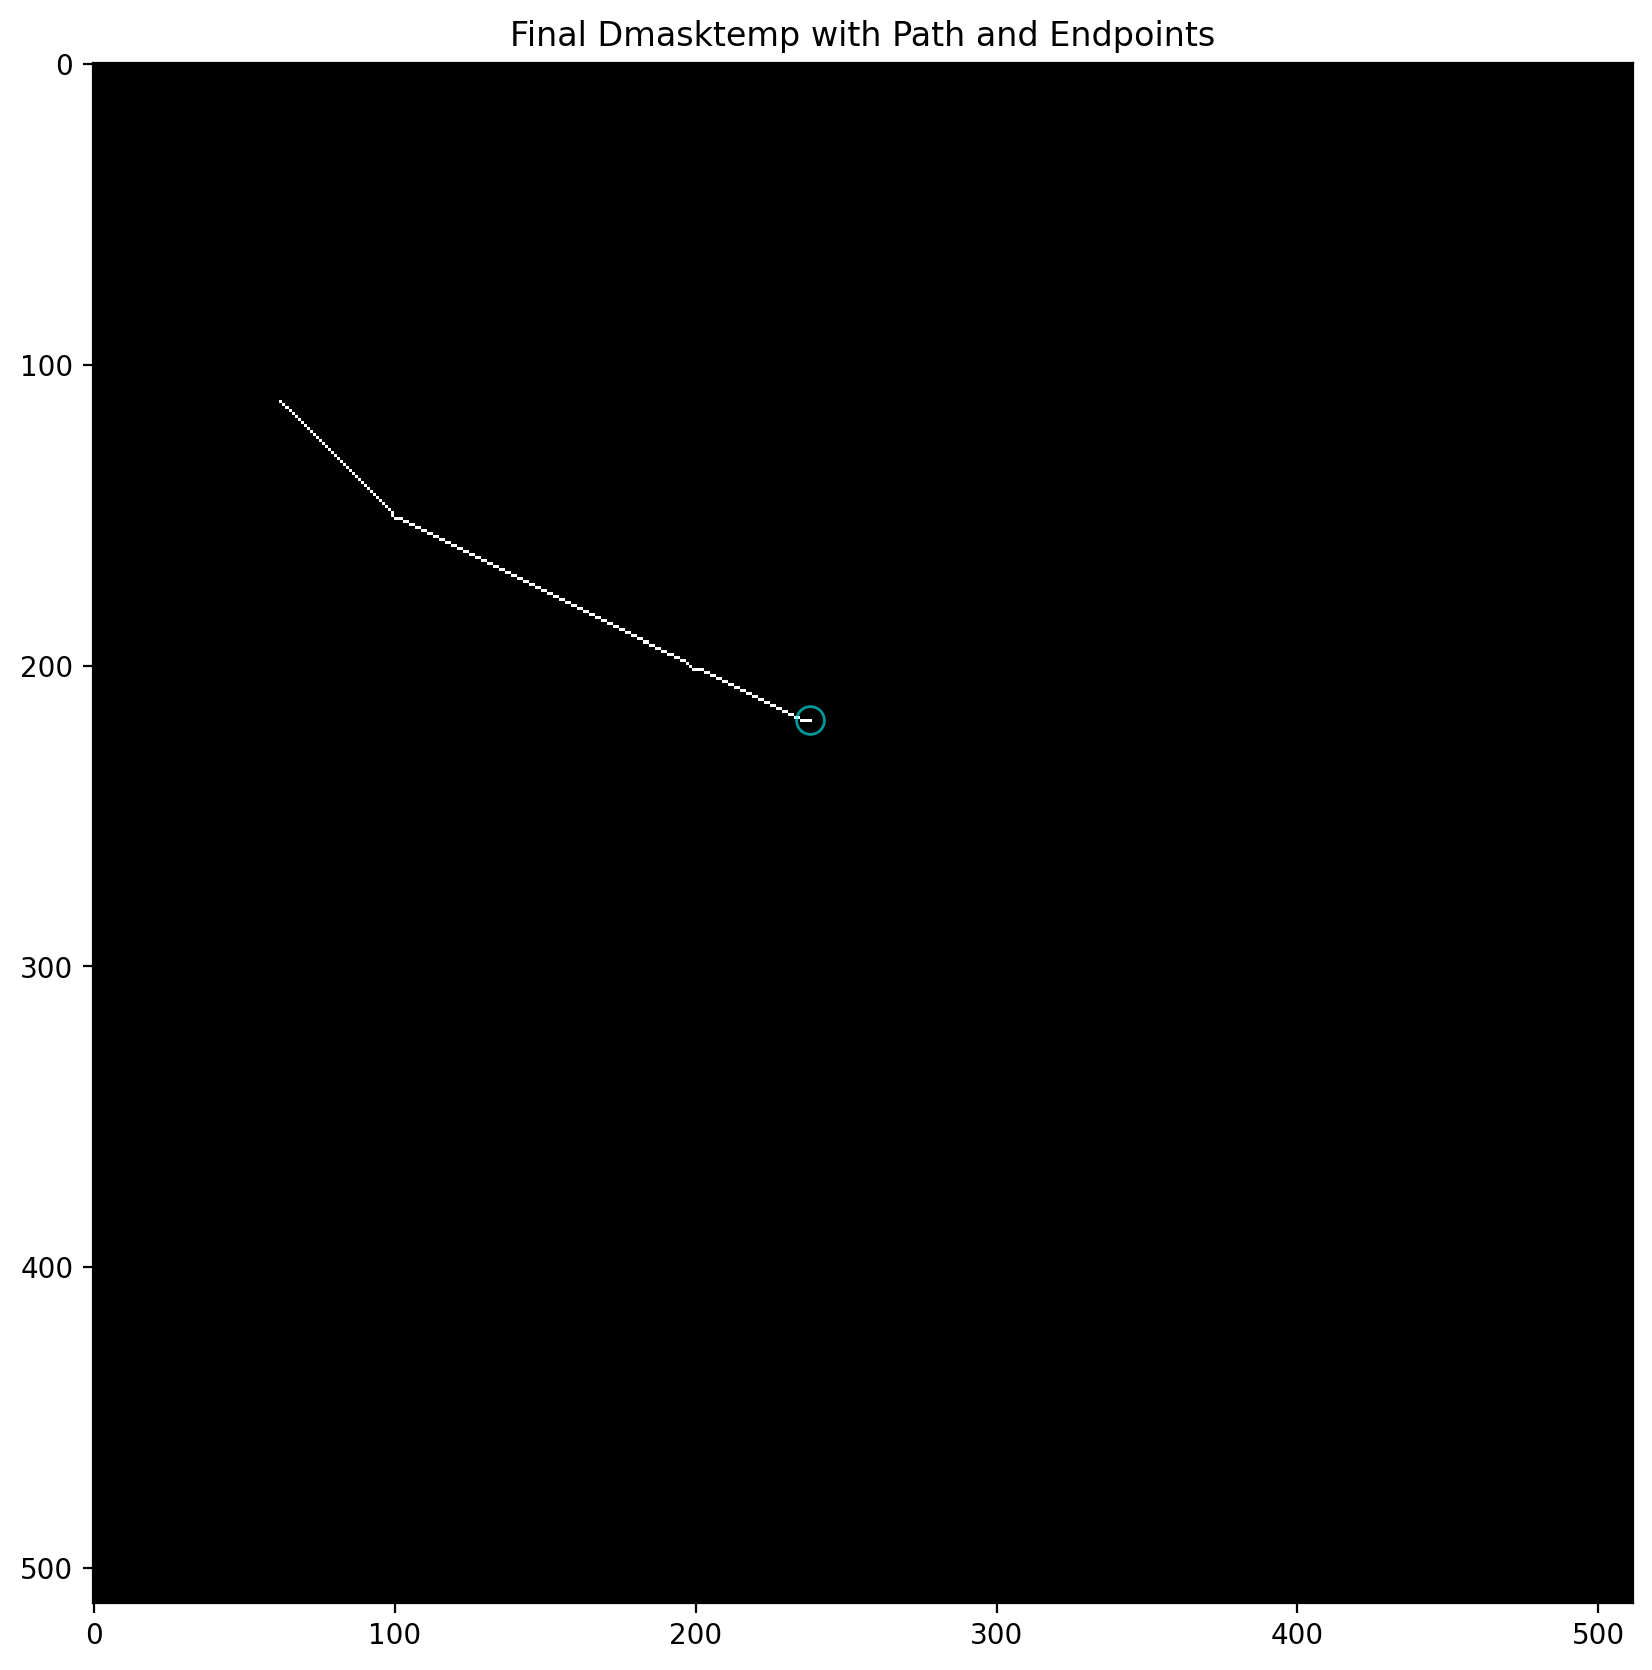


Total skeleton pixels: 183
Number of branch points found: 2
B_loctemp coordinates: [[ 62 112]]

while 3/4, Iteration 2: 2 endpoints remaining
order i =  3
Total skeleton pixels: 183
Number of branch points found: 2
Number of PTS points: 2
B_loc shape: (2, 2)
First few B_loc coordinates: [[238 217]
 [238 219]]
len(x) =  2
k =  8
k2 =  0  of  2
E location y[k2], x[k2] =  (np.int64(238), np.int64(217))


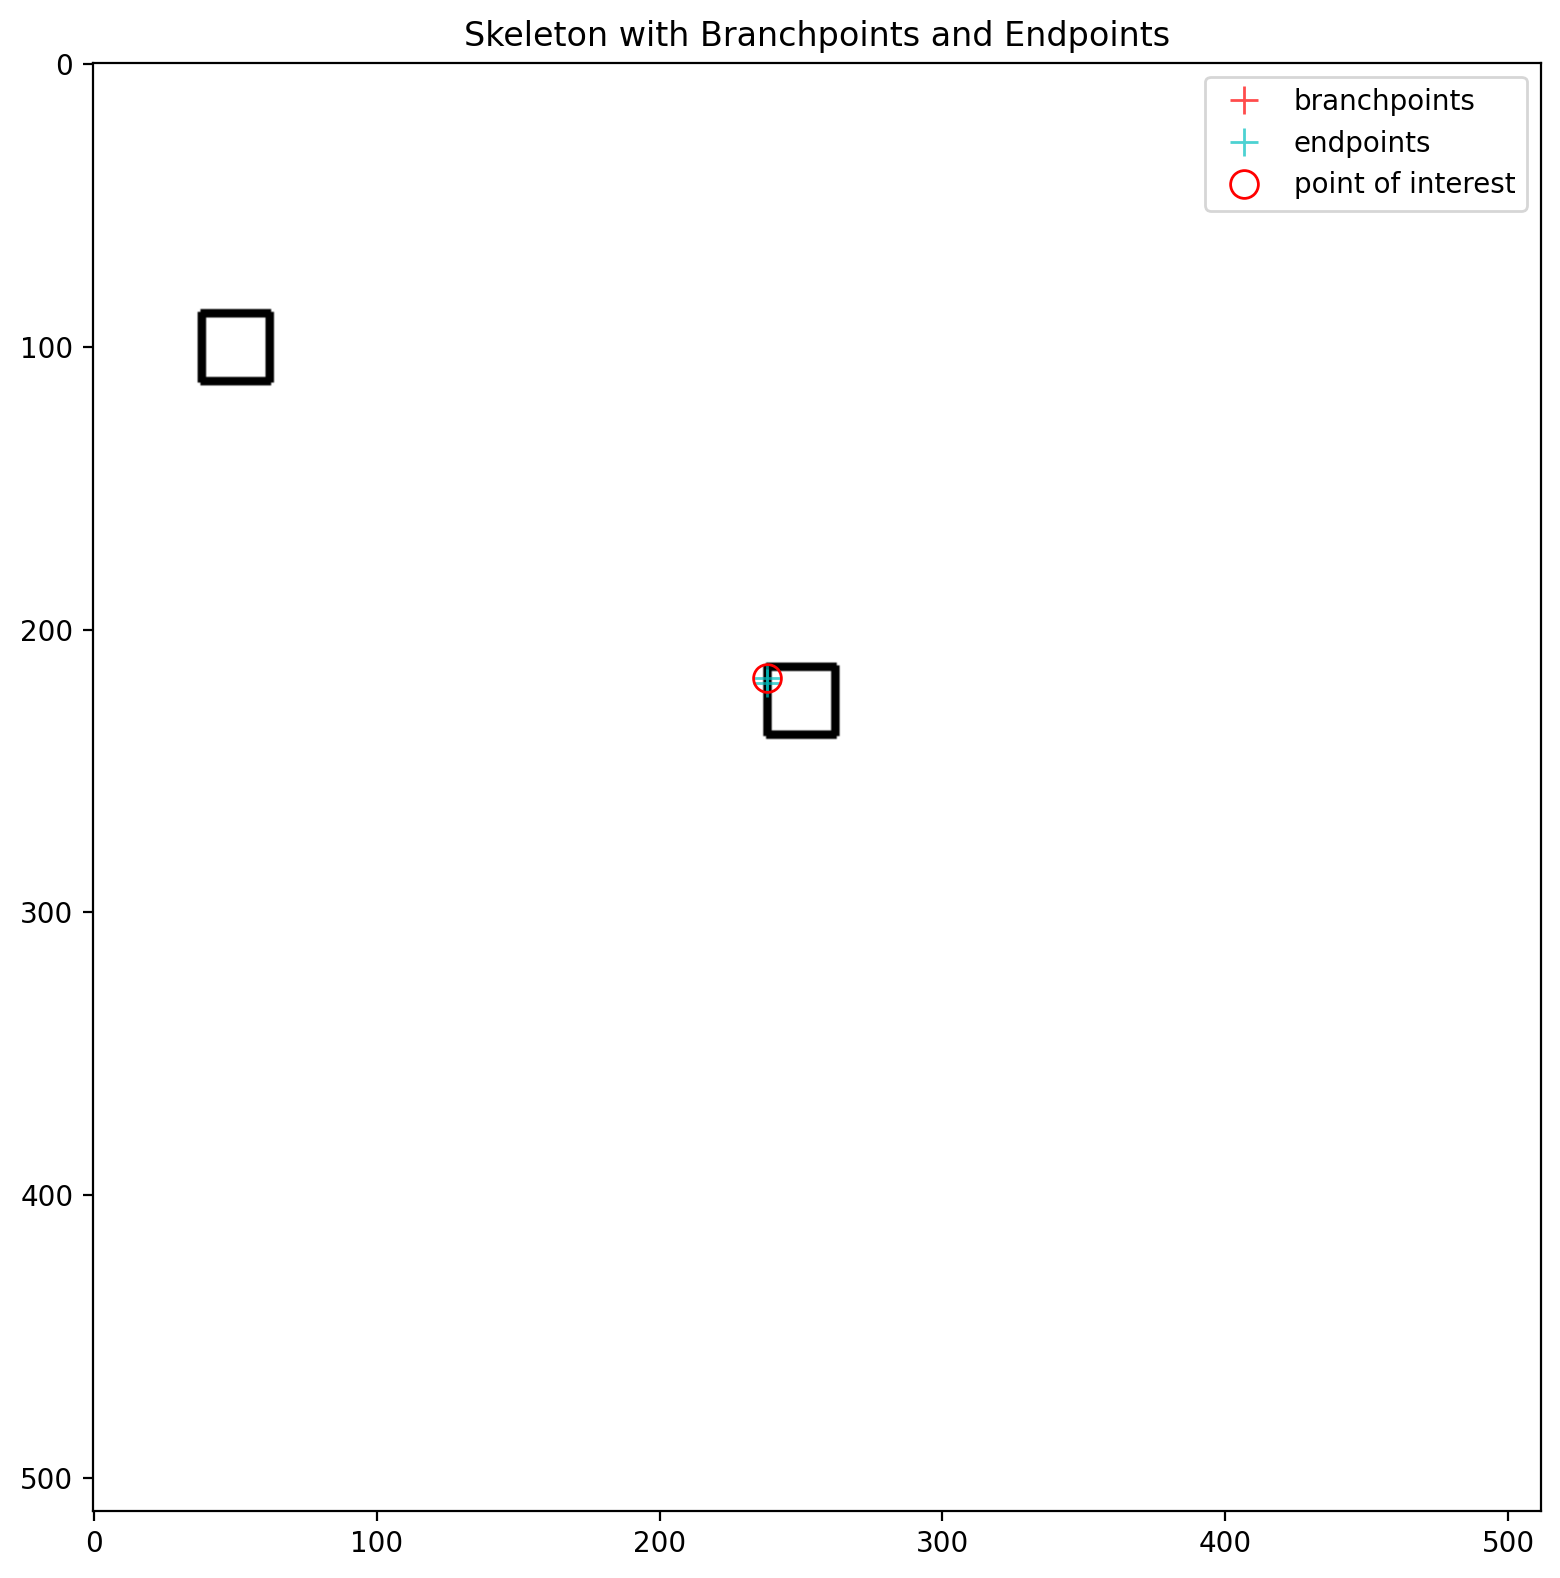

distanceToEndPt =  inf
distanceToBranchPt =  91.65685424949238
   yptend, xptend =  [238] [219]
Start point (np.int64(238), np.int64(217)) in skeleton: True
End point (np.int64(238), np.int64(219)) in skeleton: True
Cost at start: 1.0
Cost at end: 1.0


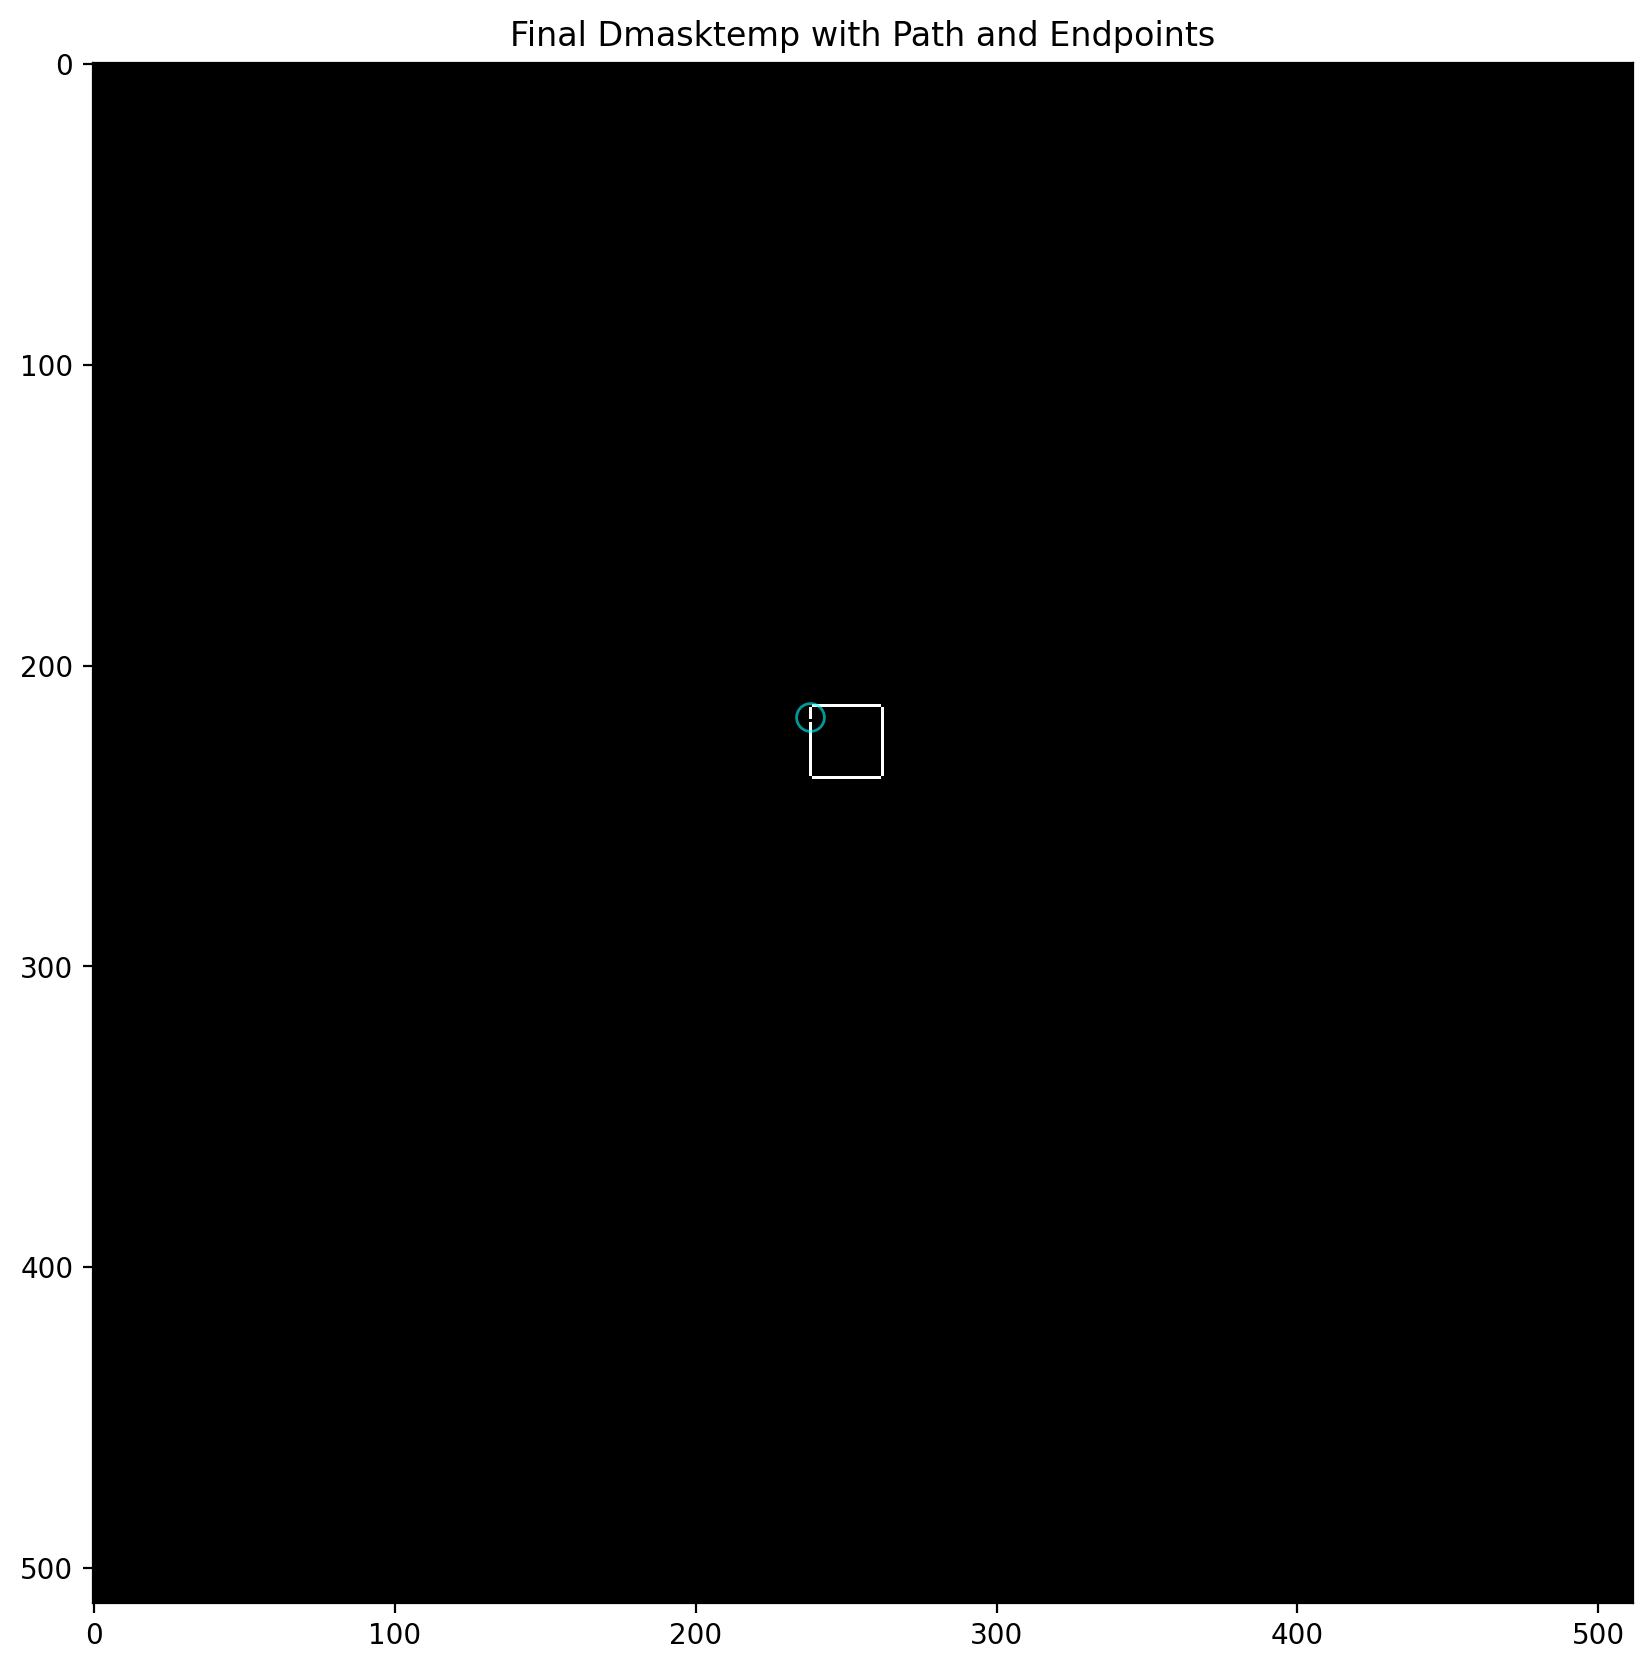


len(x) =  2
k =  9
k2 =  1  of  2
E location y[k2], x[k2] =  (np.int64(238), np.int64(219))


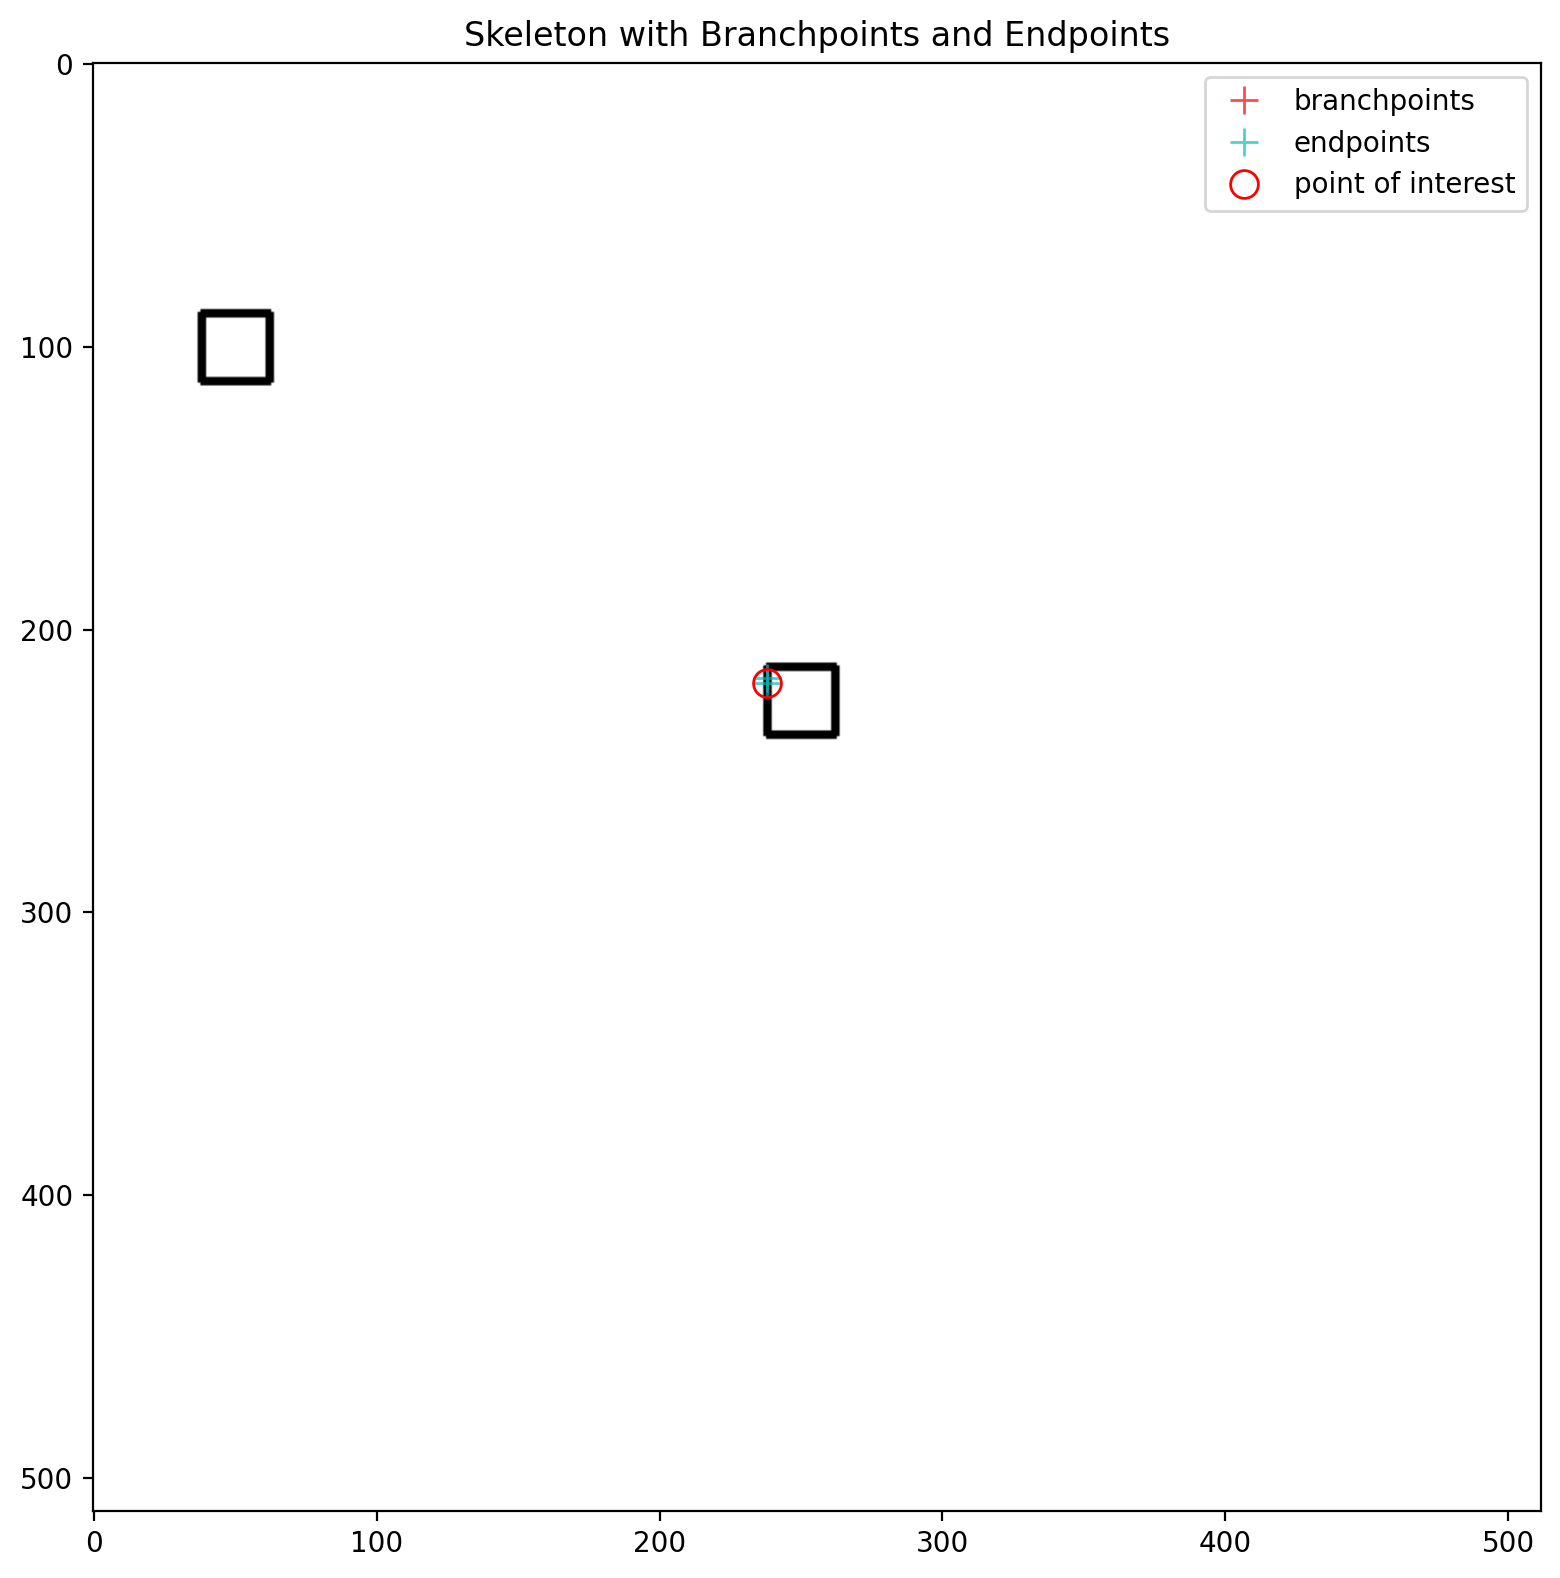

distanceToEndPt =  inf
distanceToBranchPt =  91.65685424949237
   yptend, xptend =  [238] [217]
Start point (np.int64(238), np.int64(219)) in skeleton: True
End point (np.int64(238), np.int64(217)) in skeleton: True
Cost at start: 1.0
Cost at end: 1.0


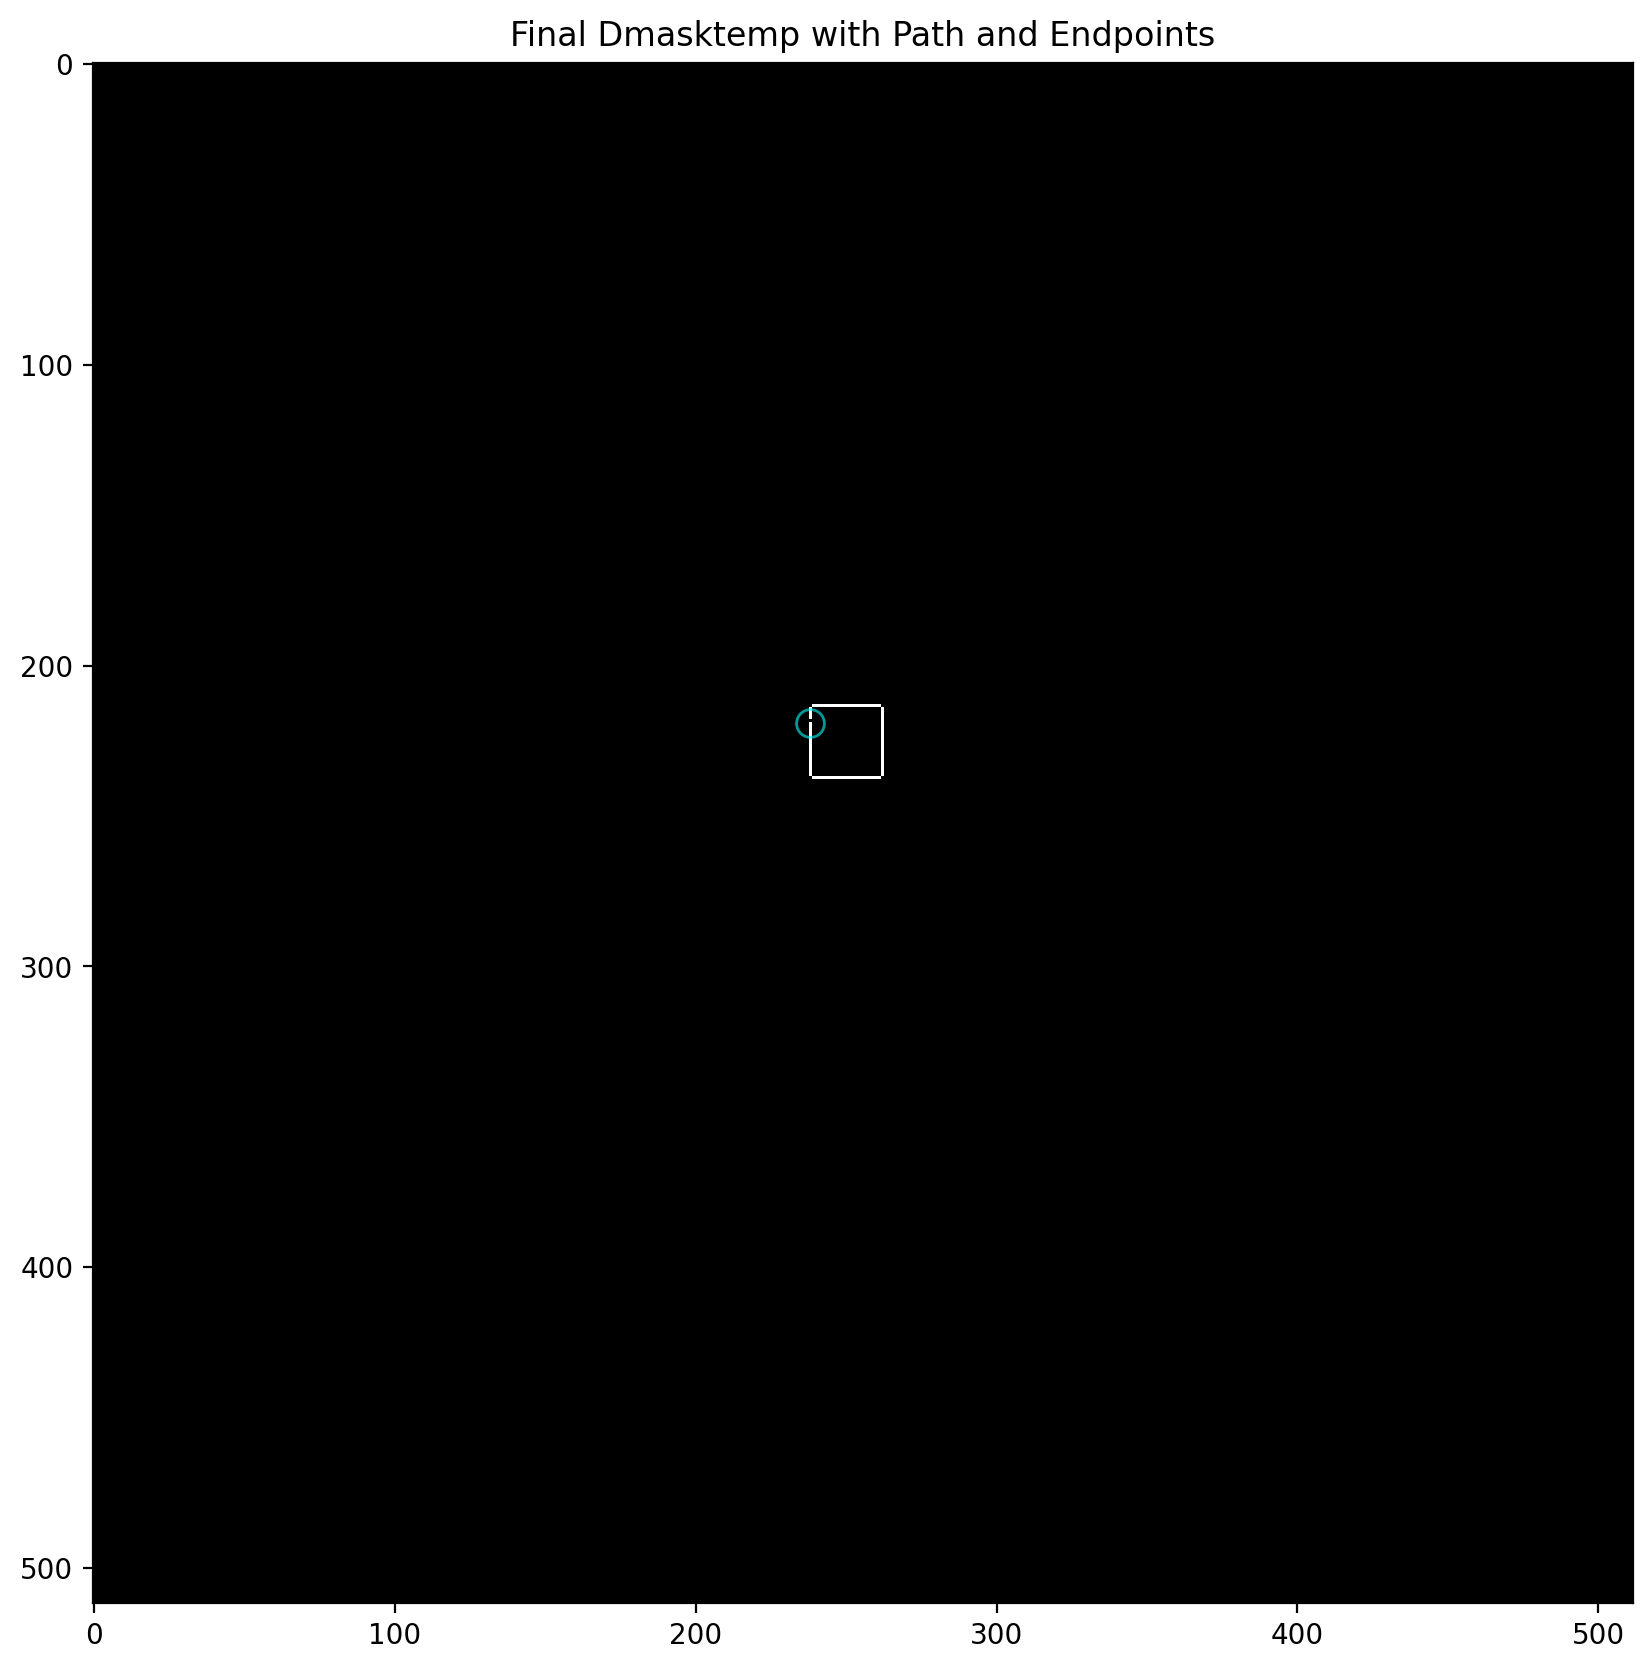


Total skeleton pixels: 92
Number of branch points found: 0
B_loctemp coordinates: [[238 217]]

Starting while loop 4 (loops):
while 4/4, Iteration 3: 92 skeleton_chopped points remaining
order i =  3


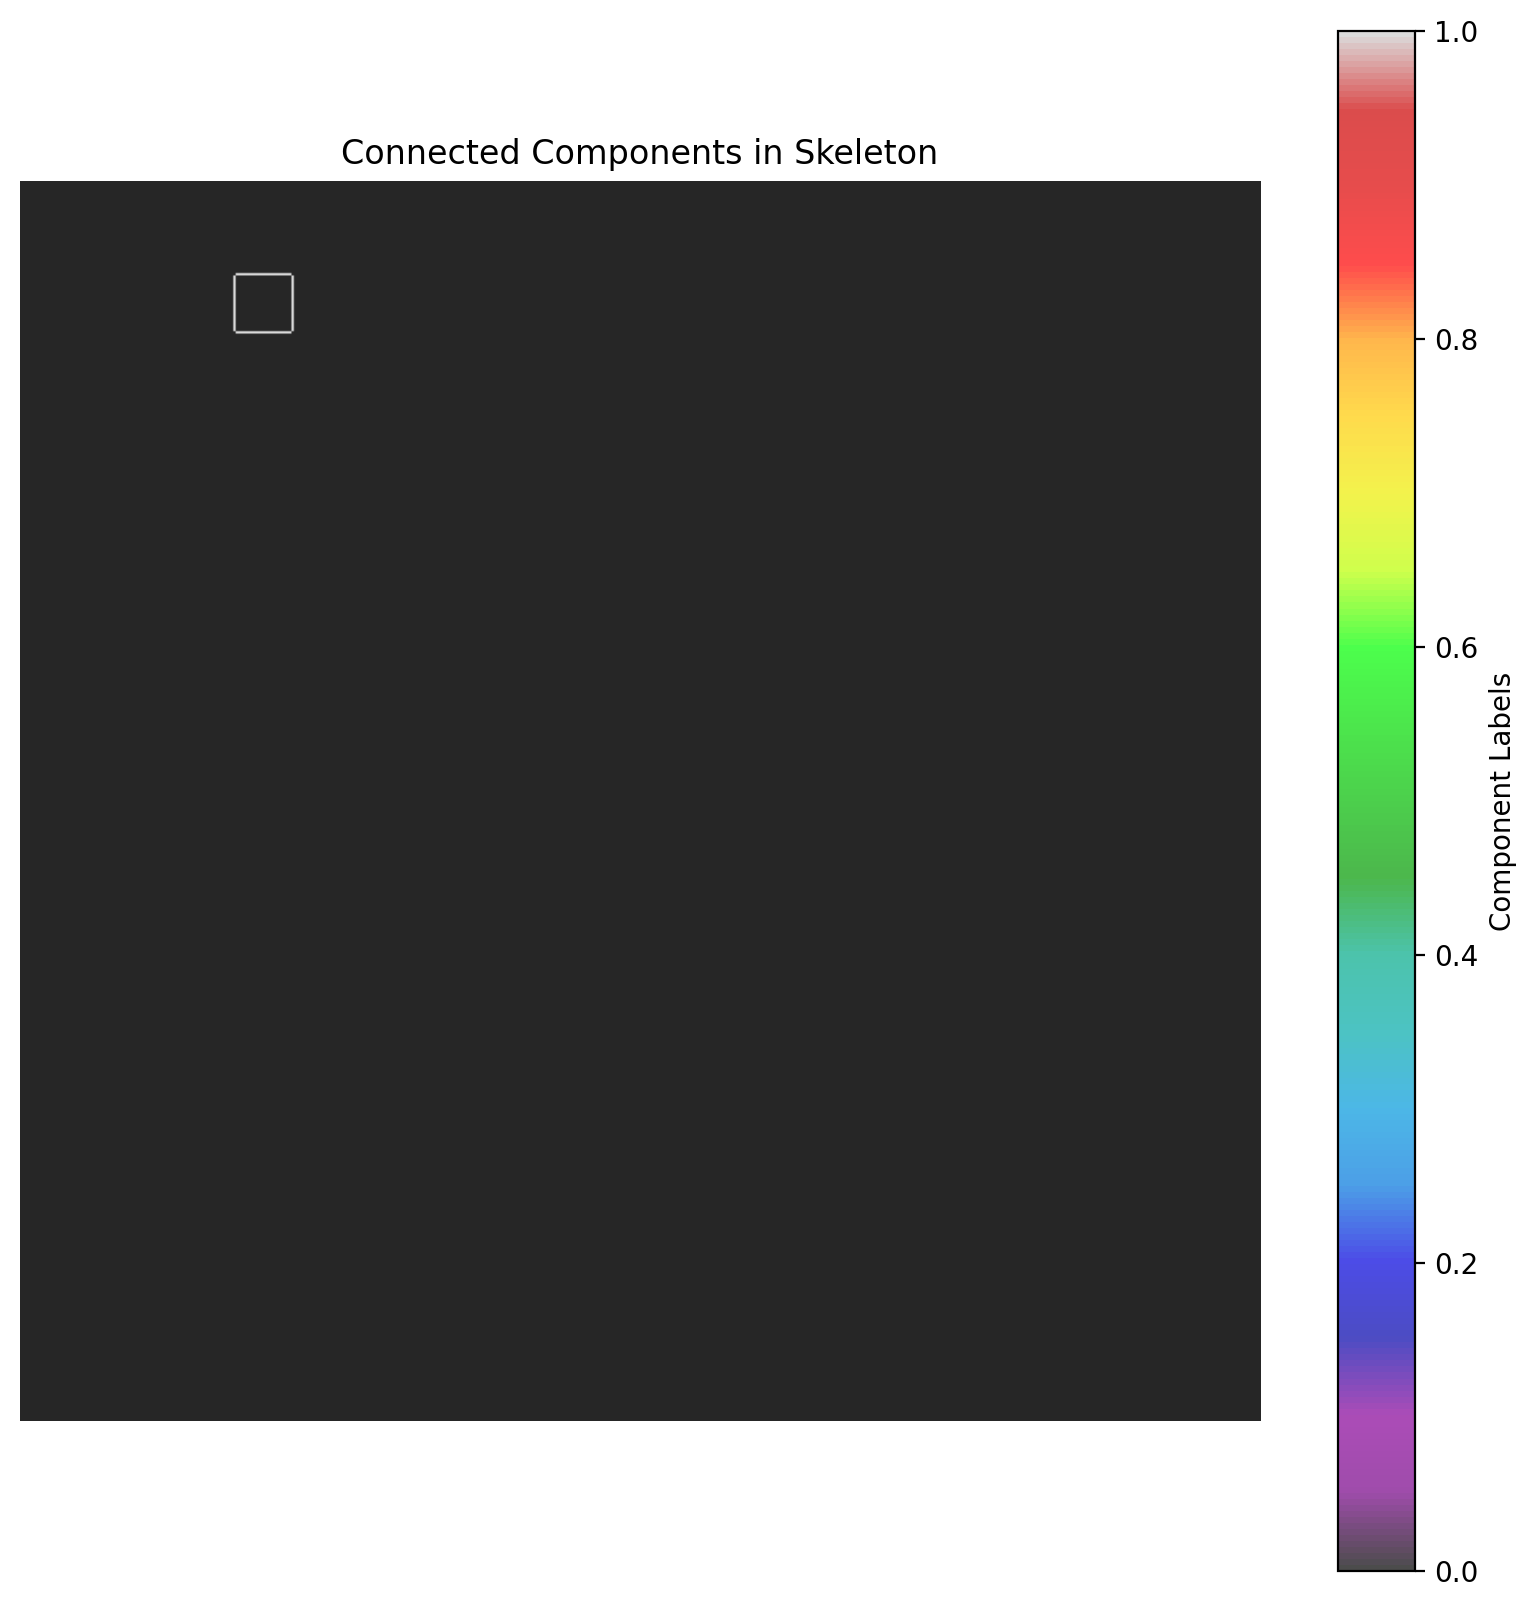

iii =  0  of  1
k =  10
Processing closed loop component 0


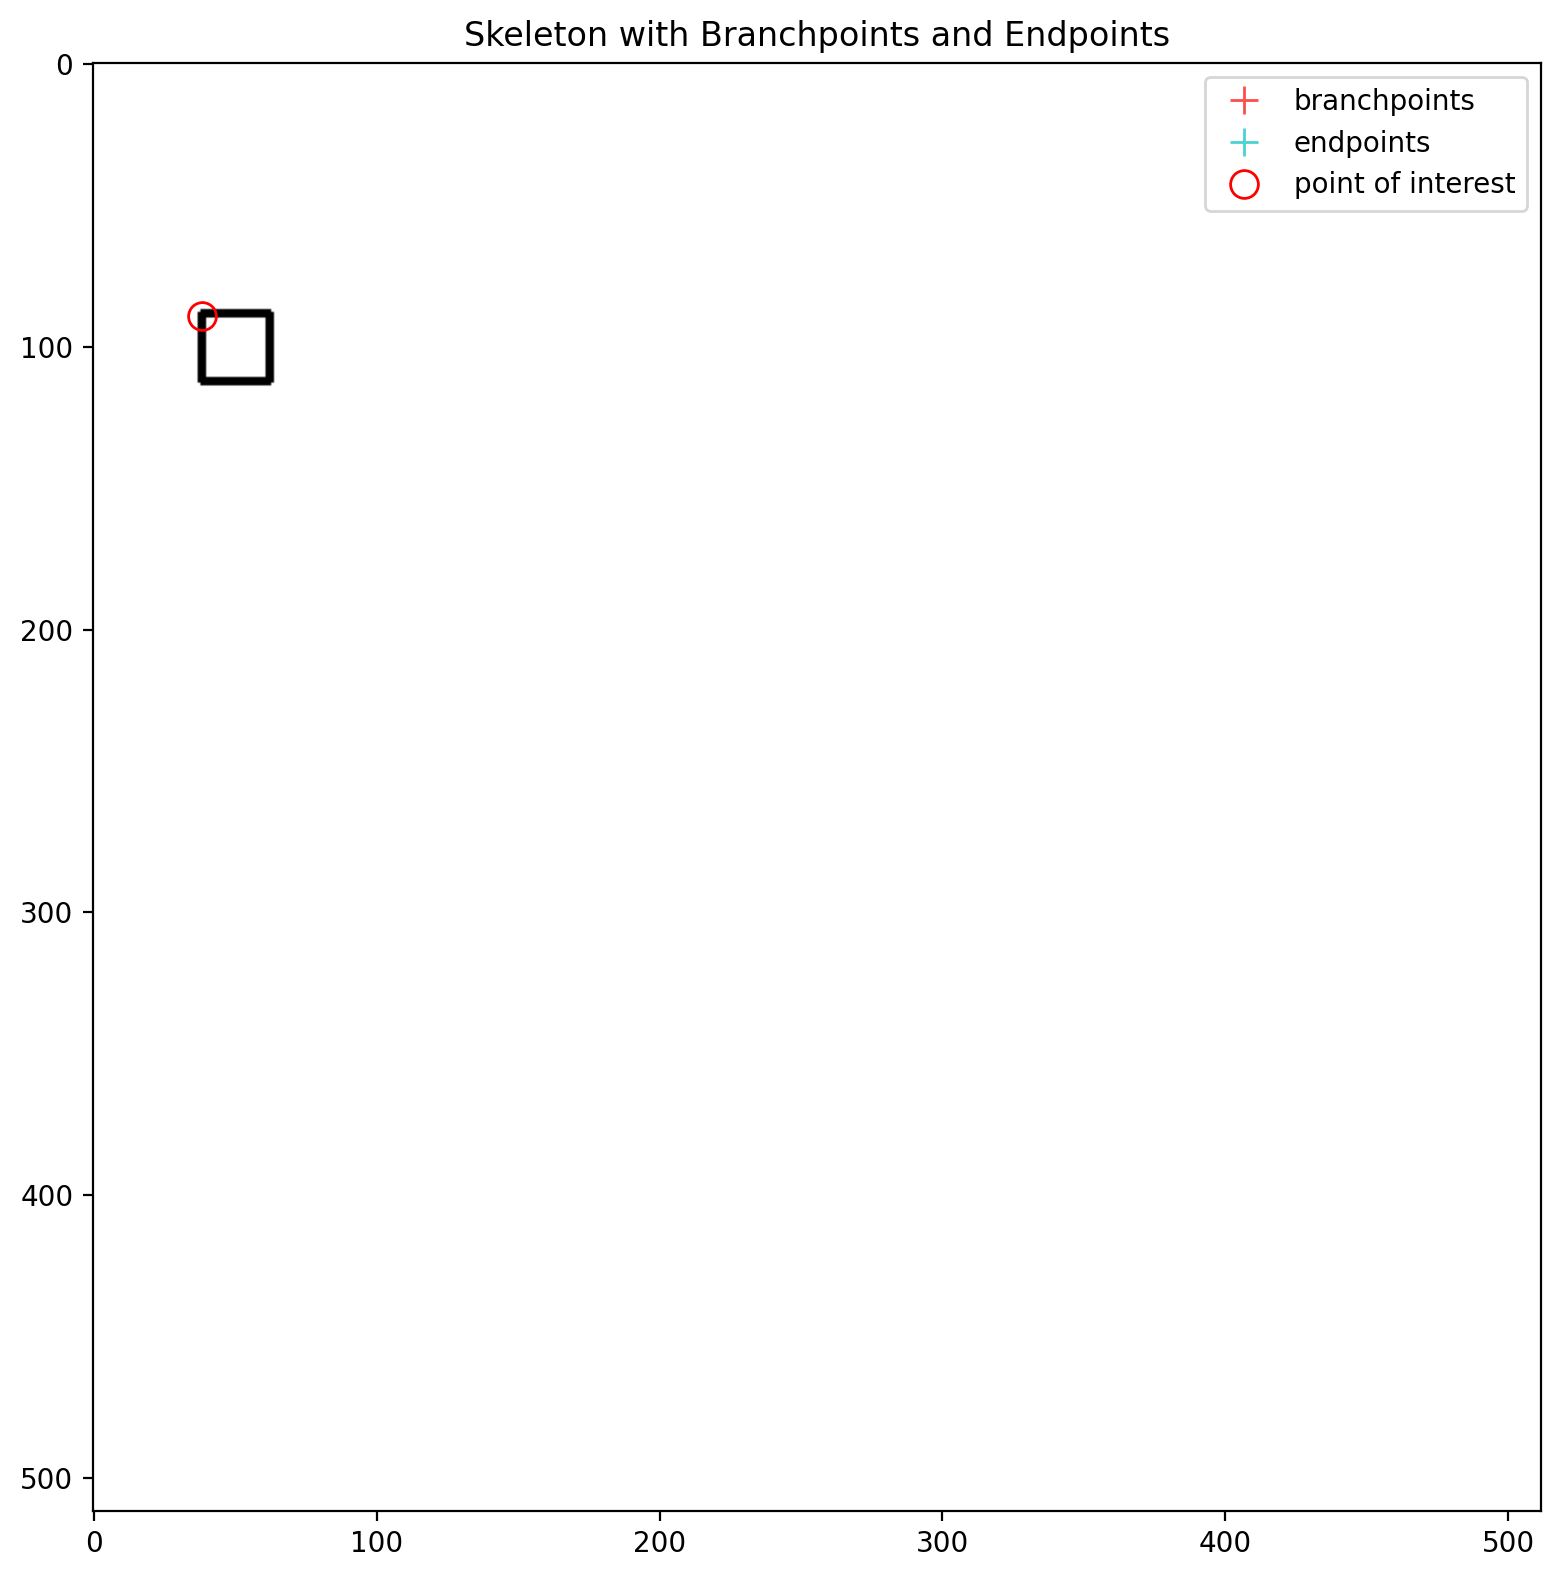

row_midpt, col_midpt: 62, 111
   yptend, xptend =  [62] [111]
Start point (np.int64(38), np.int64(89)) in skeleton: True
End point (np.int64(62), np.int64(111)) in skeleton: True
Cost at start: 1.0
Cost at end: 1.0


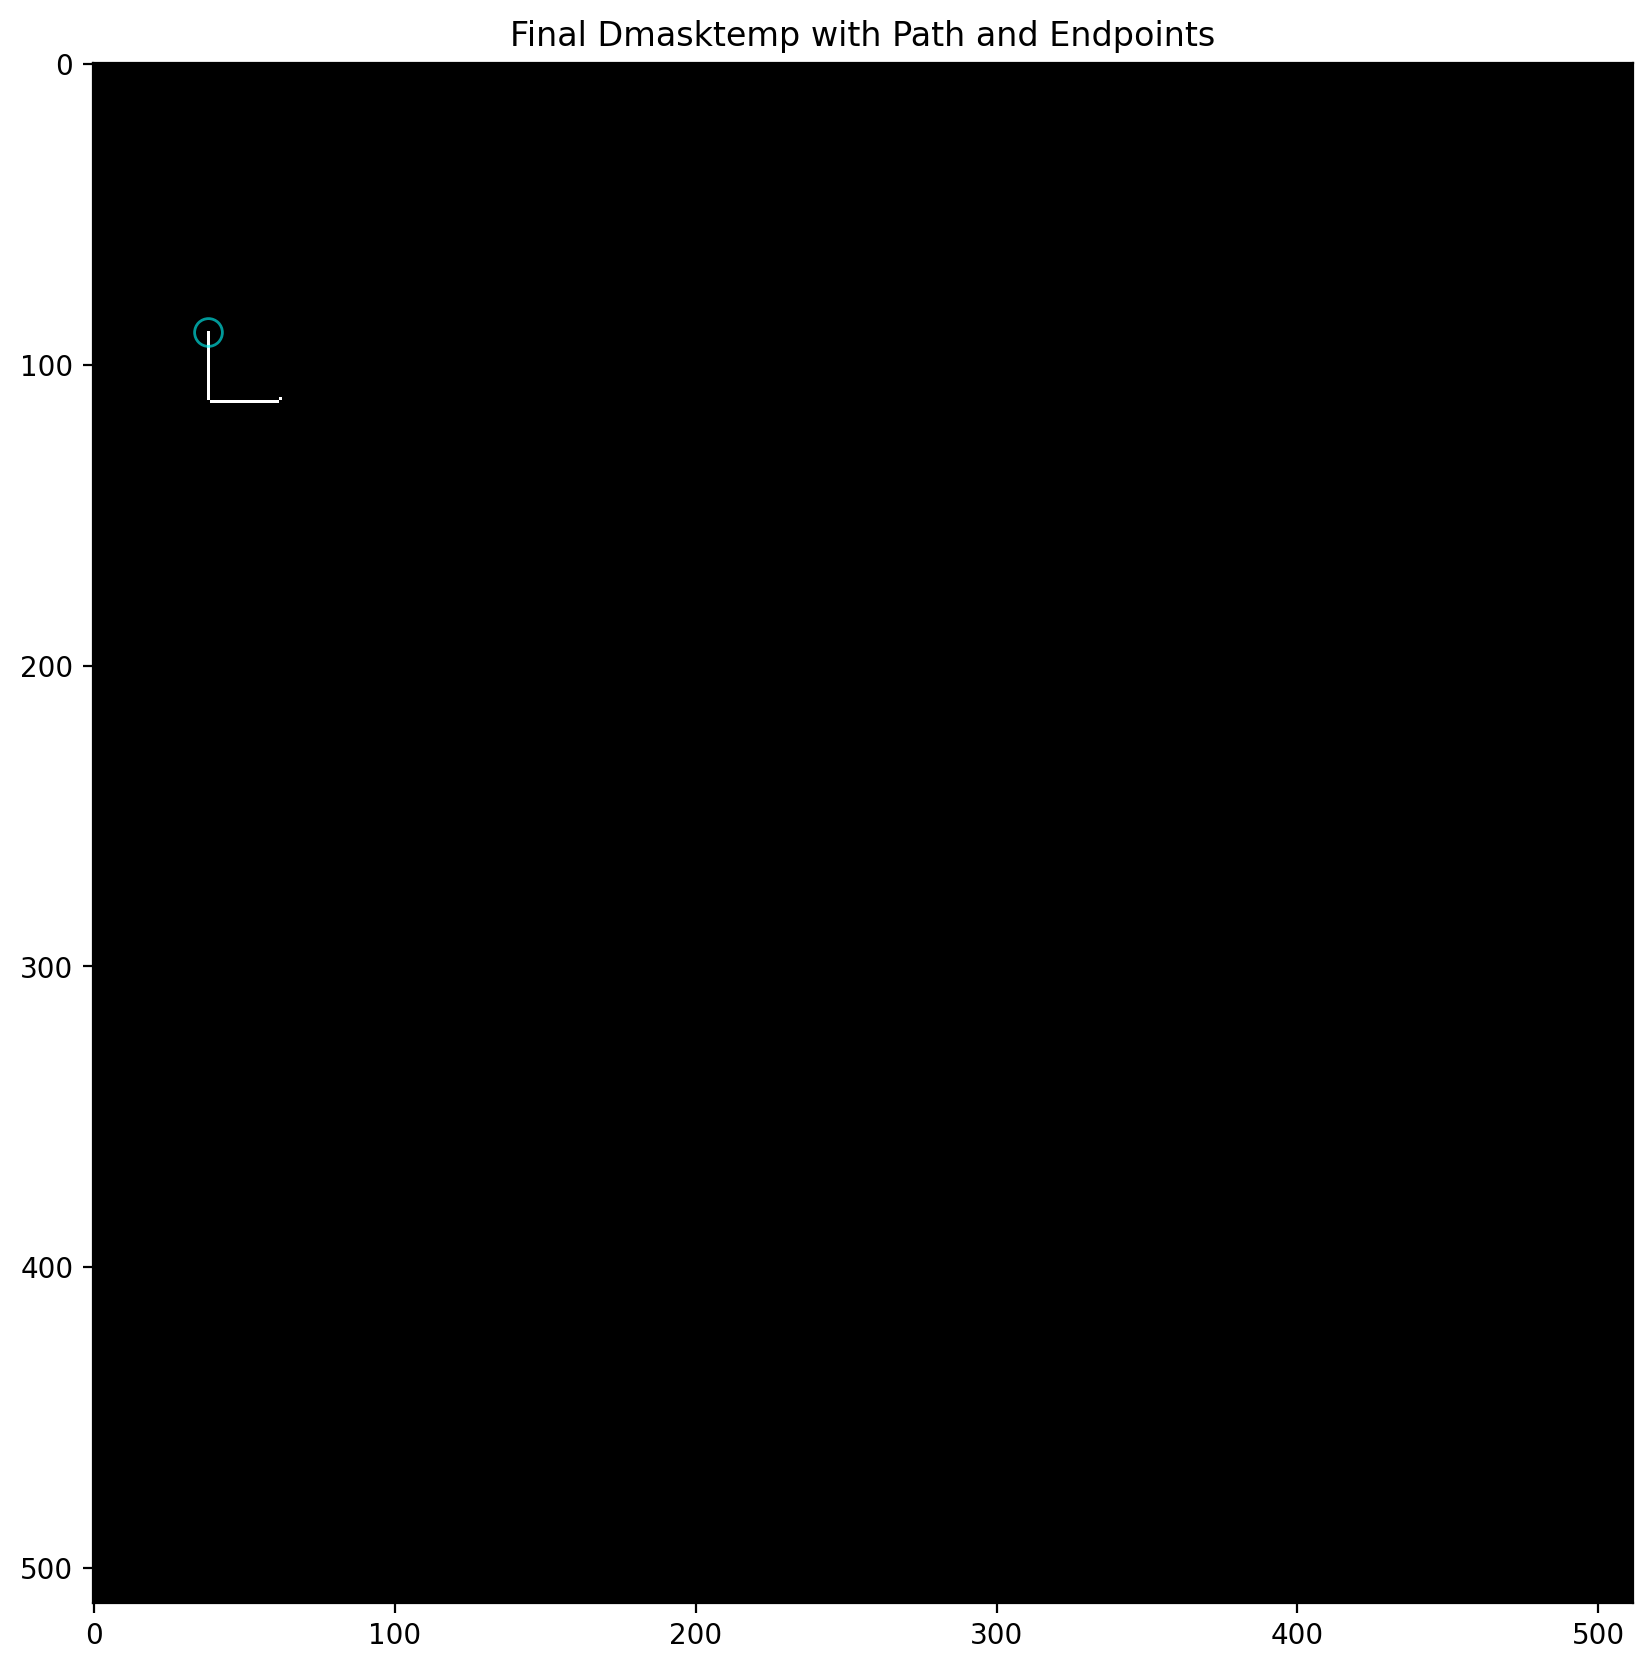


done with all while loops


In [3]:
# Section 5 - CHIROL_CREEK_ALGORITHM_2024.m
# written by Claude AI, reviewed line-by-line by Sam Kraus 2024/11/25

# import specific algorithm functions
from Creek_Ordering import figure_creek_skeleton, process_creek_ordering, process_creek_ordering_diagnostic

# # load raw creek mask from Step 4
# creekmask = load_creek_mask_h5(f'OUTPUTS/{shortname}_creekmask.h5')

# # prep data for functions
# skeleton = morphology.skeletonize(creekmask)
skeleton = skeleton_phony

# # execute functions in Creek_Ordering.py
# STRAHLER, STRAIGHTDIST, IDXSEG, IDXBRANCH, idxbreach, xbreach, ybreach, skeleton_breached, creekorder, creekordersing, PTS, ID = process_creek_ordering(ordermax, Z, skeleton, outletdetection, nbbreaches)

# diagnostic version - uncomment and run for debugging:
results_ordering = process_creek_ordering_diagnostic(ordermax=3, Z=Z, skeleton=skeleton, outletdetection=1, nbbreaches=1)
STRAHLER, STRAIGHTDIST, IDXSEG, IDXBRANCH, idxbreach, xbreach, ybreach, skeleton_breached, creekorder, creekordersing, PTS, ID = results_ordering

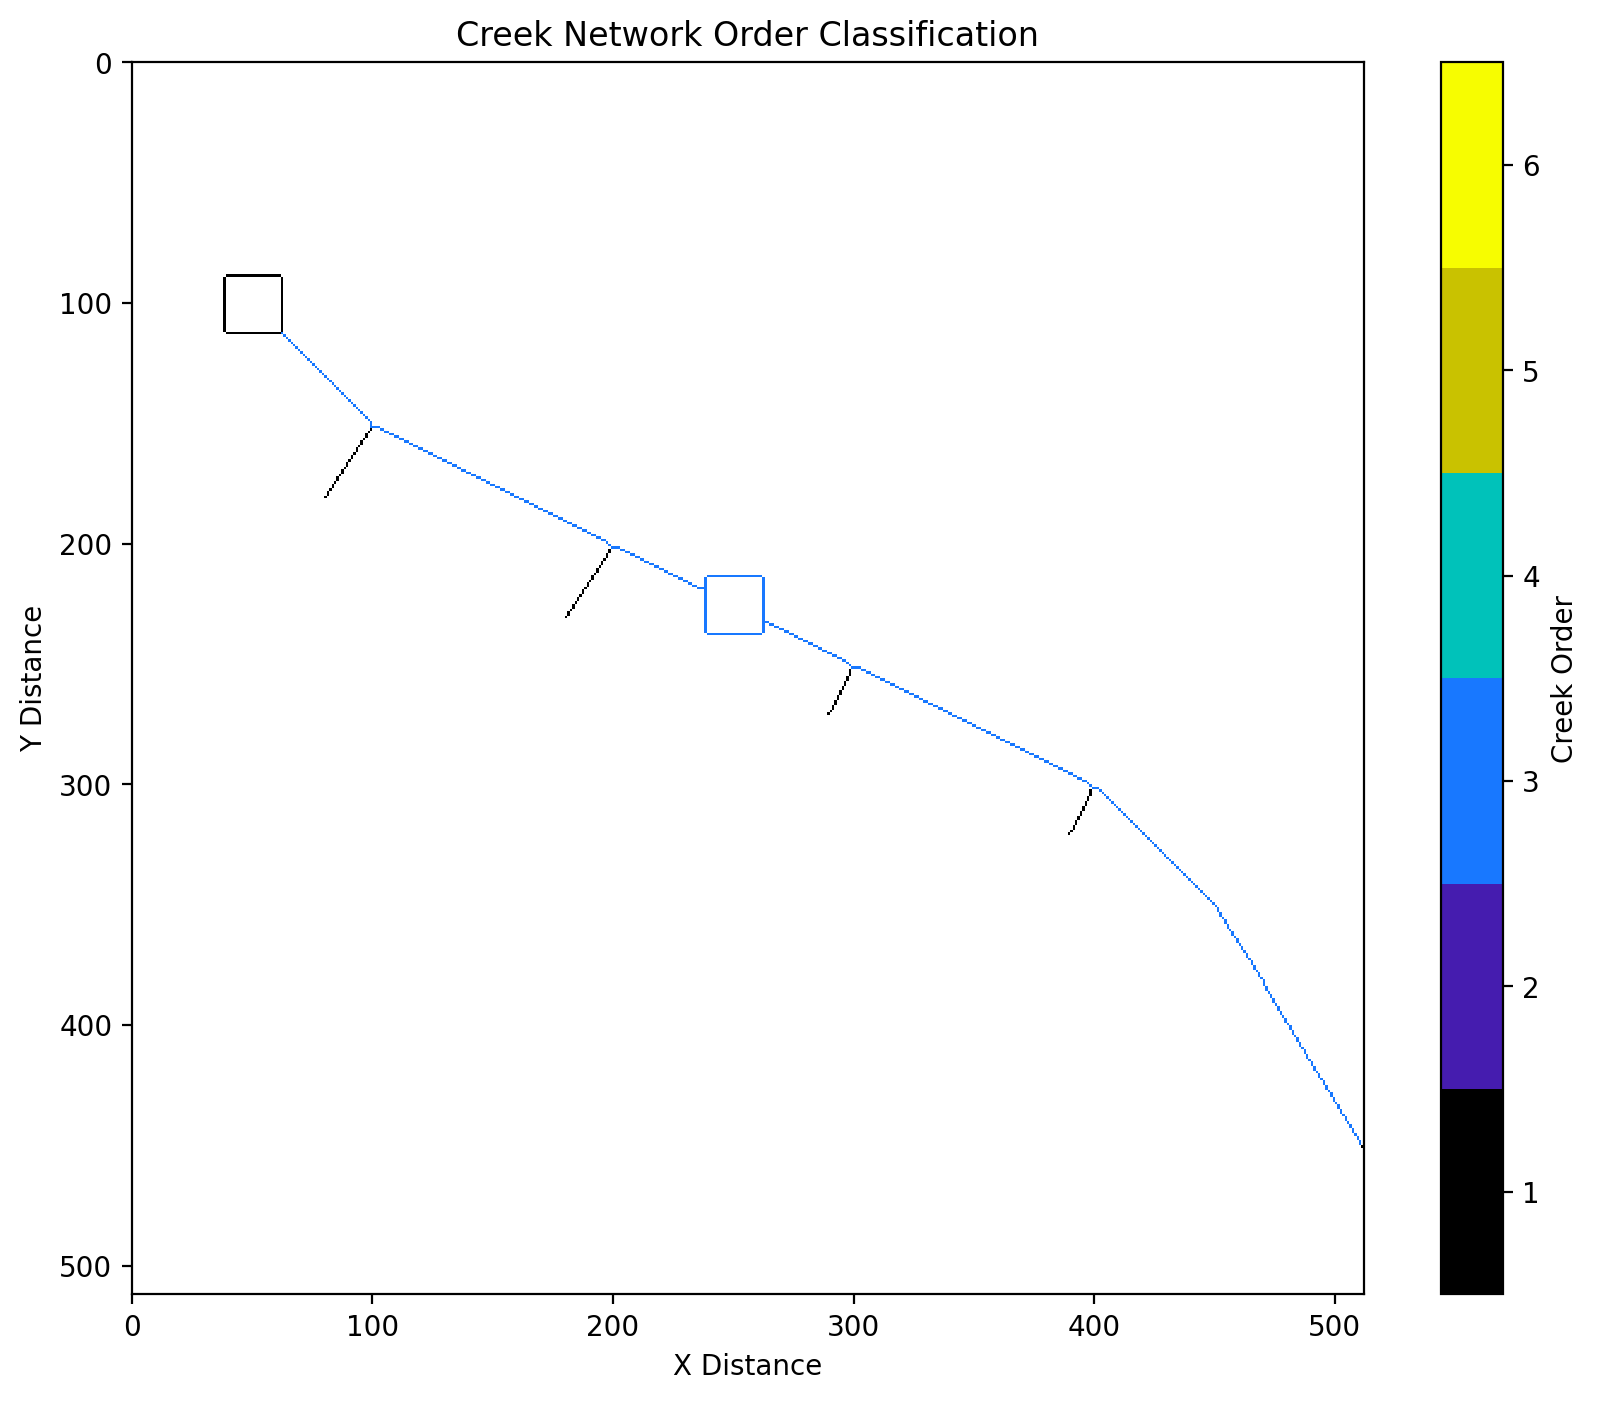

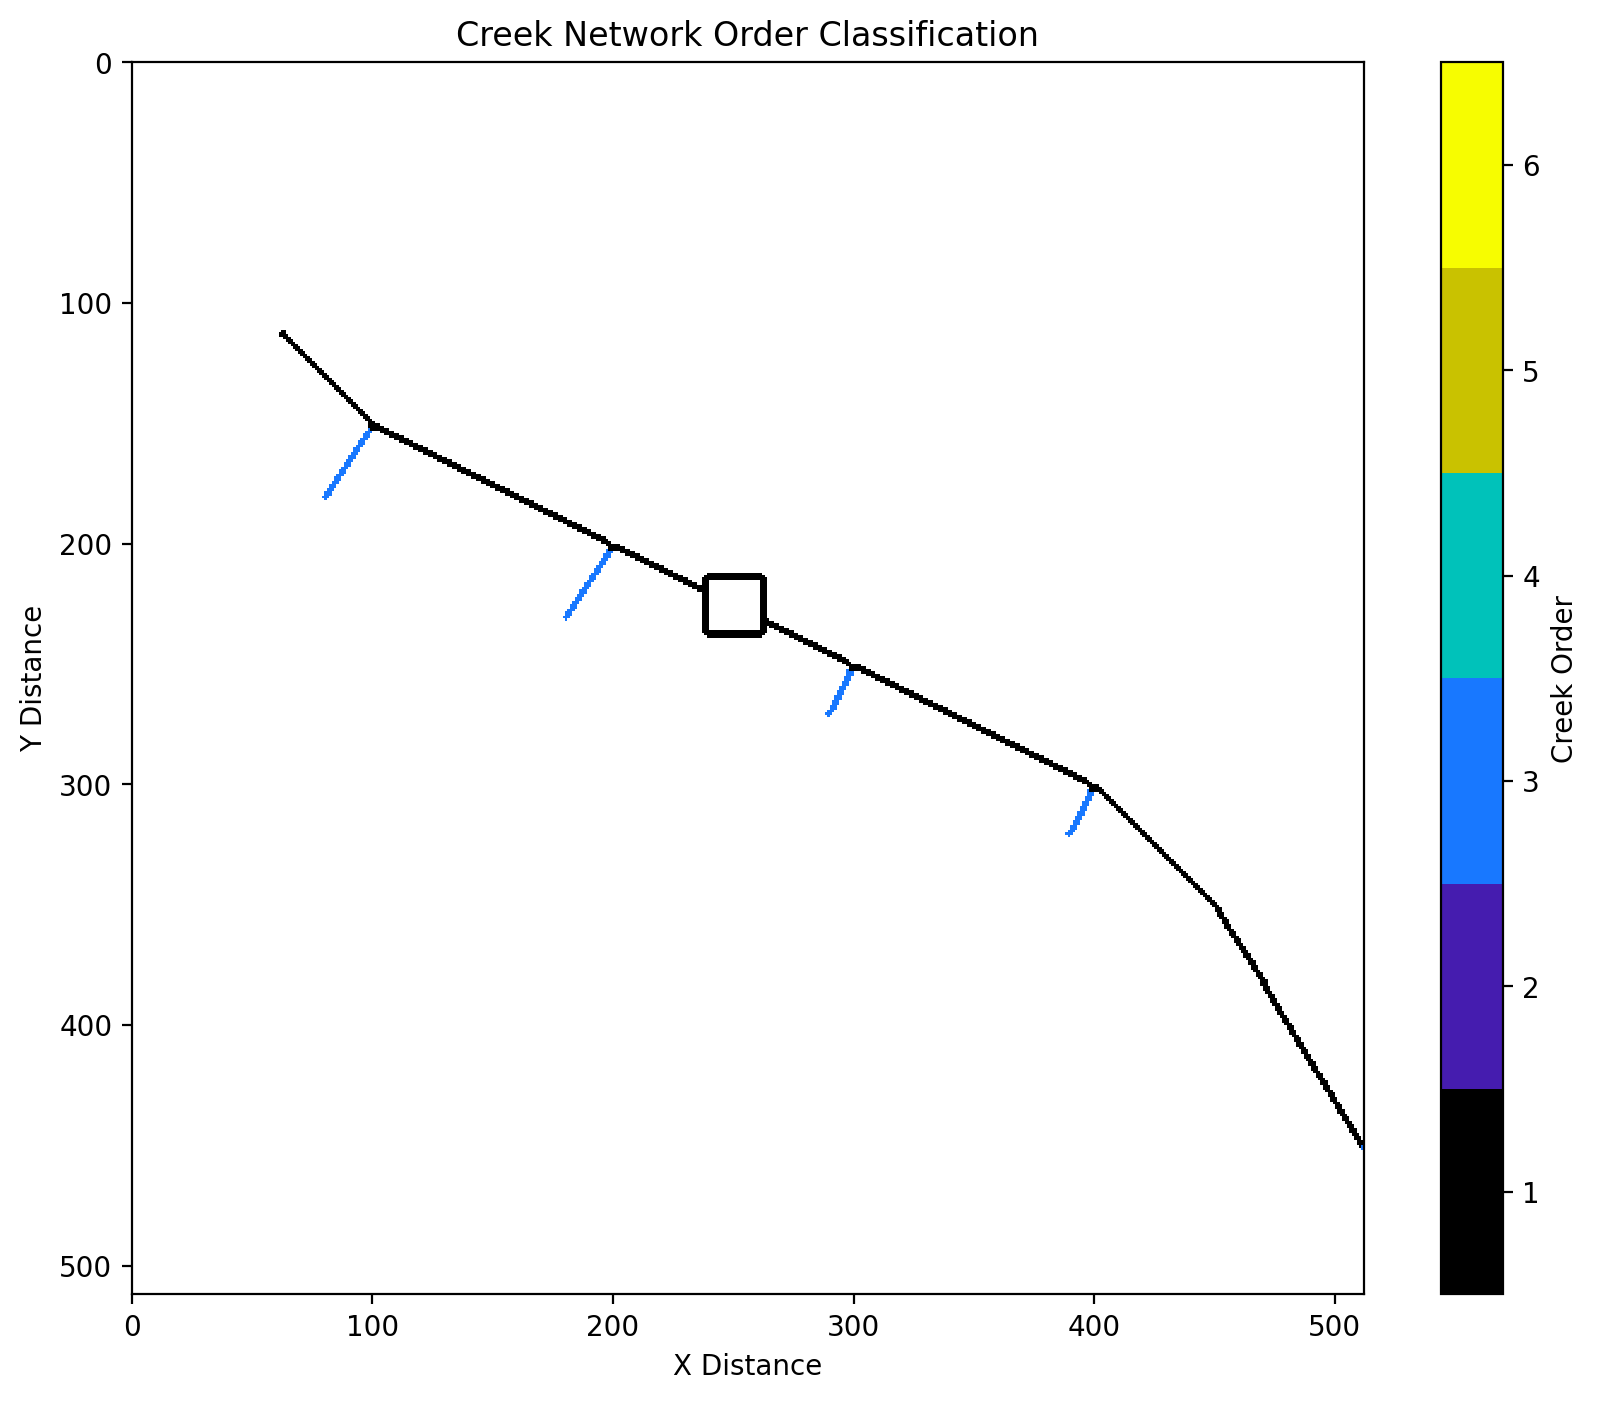

In [4]:
from check_plots_step5 import plot_creek_orders, plot_creek_orders_big

# Plot the sample data for skeleton
fig, ax = plot_creek_orders(skeleton_breached, creekordersing)
plt.show()

# Plot the sample data
fig, ax = plot_creek_orders_big(skeleton_breached, creekorder, ordermax=3, X=None, Y=None, colors=None, figsize=(10, 8), dpi=100)
plt.show()